In [0]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

In [0]:
class ACGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)
        losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=losses,
            optimizer=optimizer,
            metrics=['accuracy'])

        self.generator = self.build_generator()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        self.discriminator.trainable = False

        valid, target_label = self.discriminator(img)

        self.combined = Model([noise, label], [valid, target_label])
        self.combined.compile(loss=losses,
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=3, padding='same'))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, 100)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.summary()

        img = Input(shape=self.img_shape)

        features = model(img)

        validity = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes+1, activation="softmax")(features)

        return Model(img, [validity, label])

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (_, _) = mnist.load_data()

        # Configure inputs
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            noise = np.random.normal(0, 1, (batch_size, 100))
            sampled_labels = np.random.randint(0, 10, (batch_size, 1))
            gen_imgs = self.generator.predict([noise, sampled_labels])

            # Image labels. 0-9 if image is valid or 10 if it is generated (fake)
            img_labels = y_train[idx]
            fake_labels = 10 * np.ones(img_labels.shape)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, [valid, img_labels])
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, fake_labels])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], [valid, sampled_labels])

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]))

            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def generate(self, noise, labels):
        return self.generator.predict([noise, labels])
                
    def sample_images(self, epoch):
        r, c = 10, 10
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.array([num for _ in range(r) for num in range(c)])
        gen_imgs = self.generator.predict([noise, sampled_labels])
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 8, 8, 32)          0         
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8, 8, 32)          0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 3.336167, acc.: 51.56%, op_acc: 1.56%] [G loss: 3.682559]


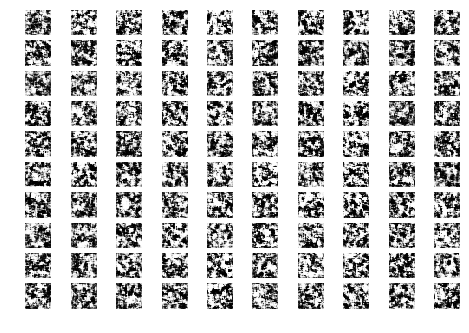

1 [D loss: 3.452207, acc.: 53.12%, op_acc: 12.50%] [G loss: 3.563743]
2 [D loss: 3.397326, acc.: 50.00%, op_acc: 7.81%] [G loss: 3.698259]
3 [D loss: 3.079416, acc.: 51.56%, op_acc: 23.44%] [G loss: 3.692555]
4 [D loss: 2.974034, acc.: 50.00%, op_acc: 20.31%] [G loss: 3.252885]
5 [D loss: 2.840678, acc.: 57.81%, op_acc: 31.25%] [G loss: 3.526730]
6 [D loss: 2.849149, acc.: 51.56%, op_acc: 39.06%] [G loss: 3.929733]
7 [D loss: 2.656076, acc.: 51.56%, op_acc: 39.06%] [G loss: 4.045725]
8 [D loss: 2.555049, acc.: 43.75%, op_acc: 48.44%] [G loss: 3.922488]
9 [D loss: 2.575383, acc.: 54.69%, op_acc: 43.75%] [G loss: 3.864307]
10 [D loss: 2.479500, acc.: 62.50%, op_acc: 46.88%] [G loss: 4.334232]
11 [D loss: 2.510279, acc.: 64.06%, op_acc: 48.44%] [G loss: 4.288277]
12 [D loss: 2.348838, acc.: 67.19%, op_acc: 50.00%] [G loss: 4.440642]
13 [D loss: 2.322445, acc.: 64.06%, op_acc: 48.44%] [G loss: 4.456884]
14 [D loss: 2.328496, acc.: 68.75%, op_acc: 51.56%] [G loss: 4.567472]
15 [D loss: 2.32

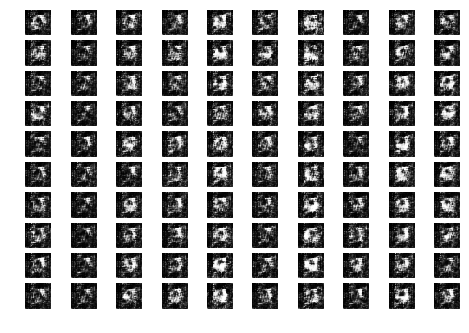

201 [D loss: 1.714834, acc.: 54.69%, op_acc: 62.50%] [G loss: 4.613948]
202 [D loss: 1.619686, acc.: 50.00%, op_acc: 76.56%] [G loss: 4.987296]
203 [D loss: 1.691355, acc.: 56.25%, op_acc: 68.75%] [G loss: 4.497769]
204 [D loss: 1.603225, acc.: 60.94%, op_acc: 70.31%] [G loss: 5.300239]
205 [D loss: 1.677686, acc.: 57.81%, op_acc: 71.88%] [G loss: 5.388903]
206 [D loss: 1.202945, acc.: 70.31%, op_acc: 84.38%] [G loss: 5.422376]
207 [D loss: 1.526194, acc.: 65.62%, op_acc: 71.88%] [G loss: 4.847564]
208 [D loss: 1.488321, acc.: 68.75%, op_acc: 71.88%] [G loss: 4.355428]
209 [D loss: 1.586943, acc.: 59.38%, op_acc: 75.00%] [G loss: 3.749577]
210 [D loss: 1.712492, acc.: 43.75%, op_acc: 70.31%] [G loss: 4.316076]
211 [D loss: 1.659068, acc.: 50.00%, op_acc: 60.94%] [G loss: 4.274969]
212 [D loss: 1.809349, acc.: 59.38%, op_acc: 64.06%] [G loss: 4.032903]
213 [D loss: 1.837997, acc.: 54.69%, op_acc: 56.25%] [G loss: 4.538437]
214 [D loss: 1.986364, acc.: 45.31%, op_acc: 56.25%] [G loss: 4.

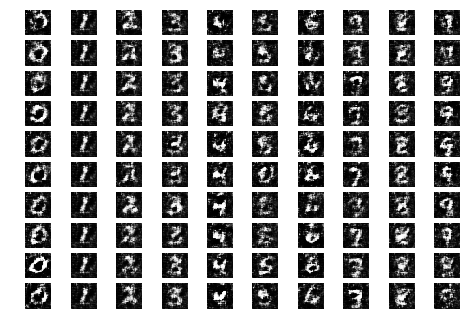

401 [D loss: 2.087389, acc.: 43.75%, op_acc: 50.00%] [G loss: 1.946525]
402 [D loss: 1.790977, acc.: 46.88%, op_acc: 53.12%] [G loss: 2.043230]
403 [D loss: 1.981209, acc.: 57.81%, op_acc: 43.75%] [G loss: 2.205779]
404 [D loss: 1.952225, acc.: 39.06%, op_acc: 46.88%] [G loss: 2.111565]
405 [D loss: 2.185707, acc.: 51.56%, op_acc: 32.81%] [G loss: 1.973046]
406 [D loss: 2.097901, acc.: 48.44%, op_acc: 43.75%] [G loss: 2.238006]
407 [D loss: 1.962045, acc.: 51.56%, op_acc: 53.12%] [G loss: 2.172466]
408 [D loss: 1.974079, acc.: 62.50%, op_acc: 40.62%] [G loss: 2.386853]
409 [D loss: 1.985287, acc.: 50.00%, op_acc: 37.50%] [G loss: 2.089630]
410 [D loss: 2.057435, acc.: 42.19%, op_acc: 48.44%] [G loss: 2.254253]
411 [D loss: 1.764123, acc.: 45.31%, op_acc: 46.88%] [G loss: 2.233313]
412 [D loss: 1.862751, acc.: 42.19%, op_acc: 43.75%] [G loss: 2.053653]
413 [D loss: 1.810200, acc.: 59.38%, op_acc: 51.56%] [G loss: 2.281920]
414 [D loss: 2.094456, acc.: 35.94%, op_acc: 46.88%] [G loss: 1.

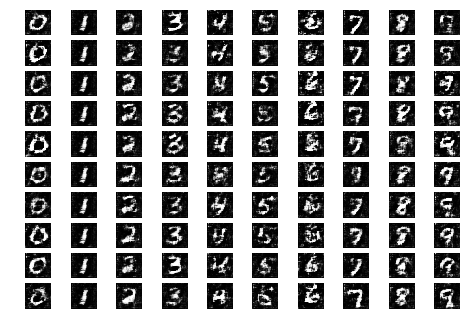

601 [D loss: 1.888135, acc.: 56.25%, op_acc: 42.19%] [G loss: 1.892773]
602 [D loss: 1.797510, acc.: 53.12%, op_acc: 48.44%] [G loss: 2.020496]
603 [D loss: 1.835961, acc.: 43.75%, op_acc: 51.56%] [G loss: 2.033081]
604 [D loss: 1.791050, acc.: 50.00%, op_acc: 42.19%] [G loss: 1.970065]
605 [D loss: 1.817147, acc.: 40.62%, op_acc: 46.88%] [G loss: 1.954792]
606 [D loss: 1.936049, acc.: 51.56%, op_acc: 43.75%] [G loss: 1.679877]
607 [D loss: 1.797874, acc.: 54.69%, op_acc: 50.00%] [G loss: 2.133180]
608 [D loss: 1.925554, acc.: 40.62%, op_acc: 43.75%] [G loss: 1.933247]
609 [D loss: 1.806685, acc.: 56.25%, op_acc: 48.44%] [G loss: 2.052150]
610 [D loss: 1.719904, acc.: 54.69%, op_acc: 54.69%] [G loss: 2.000075]
611 [D loss: 1.815392, acc.: 54.69%, op_acc: 43.75%] [G loss: 1.989384]
612 [D loss: 2.085301, acc.: 37.50%, op_acc: 43.75%] [G loss: 1.971532]
613 [D loss: 2.023431, acc.: 51.56%, op_acc: 43.75%] [G loss: 2.023740]
614 [D loss: 1.813220, acc.: 53.12%, op_acc: 42.19%] [G loss: 2.

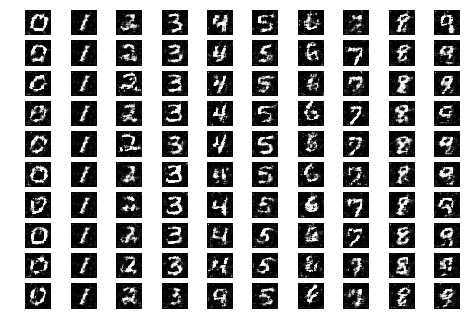

801 [D loss: 1.754126, acc.: 50.00%, op_acc: 43.75%] [G loss: 1.985833]
802 [D loss: 1.879706, acc.: 56.25%, op_acc: 43.75%] [G loss: 1.958700]
803 [D loss: 1.833094, acc.: 64.06%, op_acc: 32.81%] [G loss: 1.973840]
804 [D loss: 1.870201, acc.: 42.19%, op_acc: 50.00%] [G loss: 2.095887]
805 [D loss: 1.756688, acc.: 54.69%, op_acc: 50.00%] [G loss: 1.818847]
806 [D loss: 1.663282, acc.: 56.25%, op_acc: 53.12%] [G loss: 1.898266]
807 [D loss: 1.802914, acc.: 45.31%, op_acc: 50.00%] [G loss: 2.087530]
808 [D loss: 1.973478, acc.: 46.88%, op_acc: 34.38%] [G loss: 1.997866]
809 [D loss: 1.813496, acc.: 54.69%, op_acc: 43.75%] [G loss: 1.844280]
810 [D loss: 1.885443, acc.: 39.06%, op_acc: 35.94%] [G loss: 1.905198]
811 [D loss: 1.841565, acc.: 54.69%, op_acc: 40.62%] [G loss: 1.918367]
812 [D loss: 1.852732, acc.: 54.69%, op_acc: 42.19%] [G loss: 2.133978]
813 [D loss: 1.773706, acc.: 46.88%, op_acc: 45.31%] [G loss: 2.059533]
814 [D loss: 1.839073, acc.: 48.44%, op_acc: 45.31%] [G loss: 1.

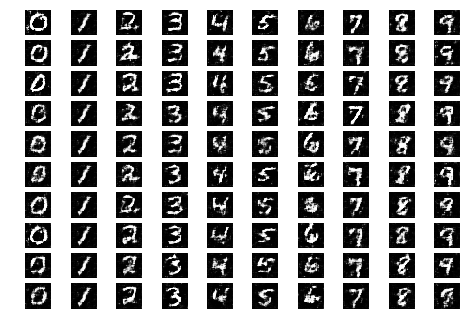

1001 [D loss: 1.767970, acc.: 54.69%, op_acc: 50.00%] [G loss: 1.878873]
1002 [D loss: 1.916240, acc.: 53.12%, op_acc: 51.56%] [G loss: 1.835795]
1003 [D loss: 1.875568, acc.: 46.88%, op_acc: 40.62%] [G loss: 1.787644]
1004 [D loss: 1.849176, acc.: 54.69%, op_acc: 43.75%] [G loss: 1.708180]
1005 [D loss: 1.728868, acc.: 51.56%, op_acc: 43.75%] [G loss: 1.993580]
1006 [D loss: 1.844058, acc.: 50.00%, op_acc: 45.31%] [G loss: 2.031873]
1007 [D loss: 1.676400, acc.: 51.56%, op_acc: 56.25%] [G loss: 1.963106]
1008 [D loss: 1.562021, acc.: 70.31%, op_acc: 60.94%] [G loss: 1.883110]
1009 [D loss: 1.798333, acc.: 50.00%, op_acc: 43.75%] [G loss: 1.884545]
1010 [D loss: 1.874659, acc.: 56.25%, op_acc: 31.25%] [G loss: 1.801090]
1011 [D loss: 1.786084, acc.: 46.88%, op_acc: 43.75%] [G loss: 2.096822]
1012 [D loss: 1.743260, acc.: 57.81%, op_acc: 40.62%] [G loss: 1.980058]
1013 [D loss: 1.829939, acc.: 40.62%, op_acc: 43.75%] [G loss: 2.083659]
1014 [D loss: 1.619987, acc.: 59.38%, op_acc: 50.00

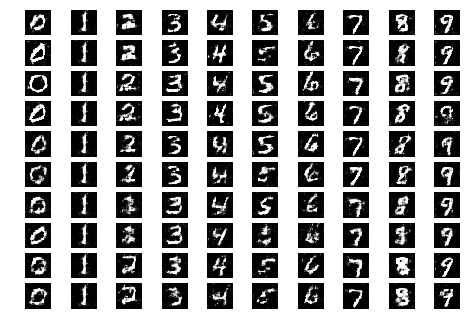

1201 [D loss: 1.810396, acc.: 53.12%, op_acc: 35.94%] [G loss: 1.958507]
1202 [D loss: 1.658202, acc.: 53.12%, op_acc: 59.38%] [G loss: 2.099726]
1203 [D loss: 1.832211, acc.: 42.19%, op_acc: 42.19%] [G loss: 1.862104]
1204 [D loss: 1.734402, acc.: 50.00%, op_acc: 45.31%] [G loss: 1.883217]
1205 [D loss: 1.821796, acc.: 51.56%, op_acc: 42.19%] [G loss: 1.867622]
1206 [D loss: 1.815126, acc.: 51.56%, op_acc: 37.50%] [G loss: 1.785384]
1207 [D loss: 1.749132, acc.: 53.12%, op_acc: 50.00%] [G loss: 1.689988]
1208 [D loss: 1.822373, acc.: 54.69%, op_acc: 42.19%] [G loss: 1.852223]
1209 [D loss: 1.718590, acc.: 53.12%, op_acc: 48.44%] [G loss: 1.826564]
1210 [D loss: 1.865675, acc.: 53.12%, op_acc: 43.75%] [G loss: 1.987226]
1211 [D loss: 1.825834, acc.: 54.69%, op_acc: 28.12%] [G loss: 1.780575]
1212 [D loss: 1.875691, acc.: 42.19%, op_acc: 46.88%] [G loss: 1.855873]
1213 [D loss: 1.697440, acc.: 45.31%, op_acc: 53.12%] [G loss: 1.789646]
1214 [D loss: 1.897234, acc.: 51.56%, op_acc: 48.44

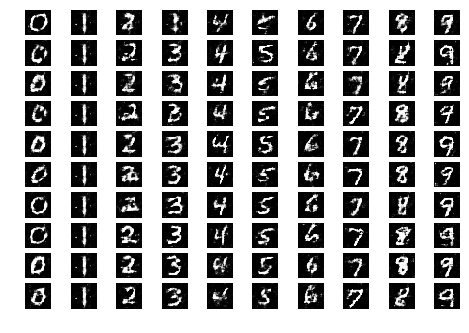

1401 [D loss: 1.692395, acc.: 59.38%, op_acc: 43.75%] [G loss: 1.758551]
1402 [D loss: 1.734376, acc.: 43.75%, op_acc: 46.88%] [G loss: 1.526189]
1403 [D loss: 1.711227, acc.: 40.62%, op_acc: 45.31%] [G loss: 1.761222]
1404 [D loss: 1.561814, acc.: 53.12%, op_acc: 54.69%] [G loss: 1.787889]
1405 [D loss: 1.700790, acc.: 54.69%, op_acc: 48.44%] [G loss: 1.729560]
1406 [D loss: 1.673320, acc.: 43.75%, op_acc: 51.56%] [G loss: 1.877250]
1407 [D loss: 1.765831, acc.: 53.12%, op_acc: 43.75%] [G loss: 1.796831]
1408 [D loss: 1.694368, acc.: 45.31%, op_acc: 39.06%] [G loss: 1.788846]
1409 [D loss: 1.737121, acc.: 56.25%, op_acc: 45.31%] [G loss: 1.853289]
1410 [D loss: 1.915174, acc.: 42.19%, op_acc: 31.25%] [G loss: 1.812199]
1411 [D loss: 1.672493, acc.: 53.12%, op_acc: 42.19%] [G loss: 1.781879]
1412 [D loss: 1.694442, acc.: 68.75%, op_acc: 46.88%] [G loss: 1.819421]
1413 [D loss: 1.774411, acc.: 60.94%, op_acc: 39.06%] [G loss: 1.958666]
1414 [D loss: 1.761835, acc.: 50.00%, op_acc: 51.56

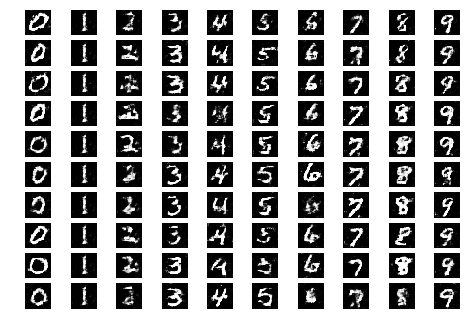

1601 [D loss: 1.785555, acc.: 51.56%, op_acc: 48.44%] [G loss: 1.853985]
1602 [D loss: 1.669533, acc.: 59.38%, op_acc: 39.06%] [G loss: 1.644292]
1603 [D loss: 1.628779, acc.: 56.25%, op_acc: 50.00%] [G loss: 1.860601]
1604 [D loss: 1.639600, acc.: 51.56%, op_acc: 43.75%] [G loss: 1.938308]
1605 [D loss: 1.723927, acc.: 54.69%, op_acc: 35.94%] [G loss: 1.664307]
1606 [D loss: 1.731429, acc.: 60.94%, op_acc: 31.25%] [G loss: 1.672584]
1607 [D loss: 1.716163, acc.: 45.31%, op_acc: 56.25%] [G loss: 1.783438]
1608 [D loss: 1.743310, acc.: 54.69%, op_acc: 31.25%] [G loss: 1.820086]
1609 [D loss: 1.608954, acc.: 57.81%, op_acc: 50.00%] [G loss: 1.843232]
1610 [D loss: 1.789074, acc.: 57.81%, op_acc: 51.56%] [G loss: 1.899539]
1611 [D loss: 1.754816, acc.: 40.62%, op_acc: 40.62%] [G loss: 1.767098]
1612 [D loss: 1.891671, acc.: 54.69%, op_acc: 35.94%] [G loss: 2.003696]
1613 [D loss: 1.794745, acc.: 39.06%, op_acc: 40.62%] [G loss: 1.520955]
1614 [D loss: 1.658003, acc.: 51.56%, op_acc: 46.88

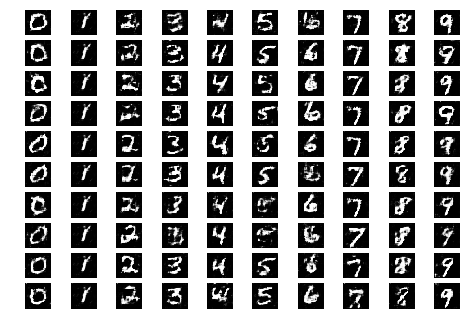

1801 [D loss: 1.619038, acc.: 46.88%, op_acc: 51.56%] [G loss: 1.710416]
1802 [D loss: 1.662375, acc.: 53.12%, op_acc: 48.44%] [G loss: 1.730852]
1803 [D loss: 1.569349, acc.: 45.31%, op_acc: 53.12%] [G loss: 1.733592]
1804 [D loss: 1.871084, acc.: 34.38%, op_acc: 31.25%] [G loss: 1.763695]
1805 [D loss: 1.651460, acc.: 42.19%, op_acc: 48.44%] [G loss: 1.853100]
1806 [D loss: 1.532525, acc.: 53.12%, op_acc: 48.44%] [G loss: 1.678730]
1807 [D loss: 1.705677, acc.: 50.00%, op_acc: 37.50%] [G loss: 1.728435]
1808 [D loss: 1.694876, acc.: 57.81%, op_acc: 45.31%] [G loss: 1.783914]
1809 [D loss: 1.637078, acc.: 51.56%, op_acc: 54.69%] [G loss: 1.630136]
1810 [D loss: 1.741105, acc.: 50.00%, op_acc: 50.00%] [G loss: 1.819279]
1811 [D loss: 1.703229, acc.: 56.25%, op_acc: 42.19%] [G loss: 1.818055]
1812 [D loss: 1.684680, acc.: 50.00%, op_acc: 50.00%] [G loss: 1.659617]
1813 [D loss: 1.624759, acc.: 59.38%, op_acc: 56.25%] [G loss: 1.716867]
1814 [D loss: 1.621119, acc.: 54.69%, op_acc: 53.12

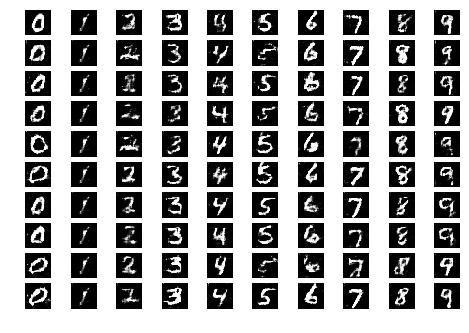

2001 [D loss: 1.627610, acc.: 54.69%, op_acc: 53.12%] [G loss: 1.794677]
2002 [D loss: 1.872279, acc.: 43.75%, op_acc: 37.50%] [G loss: 1.846385]
2003 [D loss: 1.543039, acc.: 60.94%, op_acc: 45.31%] [G loss: 1.871197]
2004 [D loss: 1.556042, acc.: 65.62%, op_acc: 50.00%] [G loss: 1.855986]
2005 [D loss: 1.719603, acc.: 46.88%, op_acc: 45.31%] [G loss: 1.998177]
2006 [D loss: 1.706230, acc.: 51.56%, op_acc: 40.62%] [G loss: 1.694901]
2007 [D loss: 1.680937, acc.: 48.44%, op_acc: 46.88%] [G loss: 1.742180]
2008 [D loss: 1.805547, acc.: 54.69%, op_acc: 42.19%] [G loss: 1.567725]
2009 [D loss: 1.777562, acc.: 43.75%, op_acc: 50.00%] [G loss: 1.717167]
2010 [D loss: 1.622272, acc.: 43.75%, op_acc: 50.00%] [G loss: 1.777252]
2011 [D loss: 1.561579, acc.: 56.25%, op_acc: 50.00%] [G loss: 1.734379]
2012 [D loss: 1.625226, acc.: 59.38%, op_acc: 45.31%] [G loss: 1.784371]
2013 [D loss: 1.874886, acc.: 54.69%, op_acc: 20.31%] [G loss: 1.473385]
2014 [D loss: 1.773747, acc.: 48.44%, op_acc: 45.31

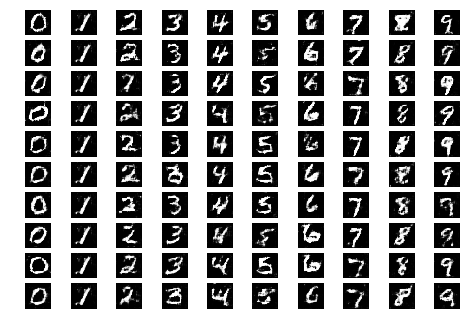

2201 [D loss: 1.833763, acc.: 50.00%, op_acc: 35.94%] [G loss: 1.662182]
2202 [D loss: 1.627794, acc.: 57.81%, op_acc: 42.19%] [G loss: 1.789653]
2203 [D loss: 1.569285, acc.: 62.50%, op_acc: 50.00%] [G loss: 1.671061]
2204 [D loss: 1.737792, acc.: 45.31%, op_acc: 42.19%] [G loss: 1.609388]
2205 [D loss: 1.706775, acc.: 43.75%, op_acc: 42.19%] [G loss: 1.854439]
2206 [D loss: 1.637286, acc.: 54.69%, op_acc: 46.88%] [G loss: 1.830711]
2207 [D loss: 1.625803, acc.: 59.38%, op_acc: 45.31%] [G loss: 1.800812]
2208 [D loss: 1.742508, acc.: 46.88%, op_acc: 43.75%] [G loss: 1.640982]
2209 [D loss: 1.604159, acc.: 54.69%, op_acc: 48.44%] [G loss: 1.475133]
2210 [D loss: 1.559888, acc.: 67.19%, op_acc: 50.00%] [G loss: 1.625156]
2211 [D loss: 1.550506, acc.: 51.56%, op_acc: 46.88%] [G loss: 1.691783]
2212 [D loss: 1.660762, acc.: 62.50%, op_acc: 45.31%] [G loss: 1.634847]
2213 [D loss: 1.662968, acc.: 60.94%, op_acc: 45.31%] [G loss: 1.751228]
2214 [D loss: 1.661660, acc.: 42.19%, op_acc: 45.31

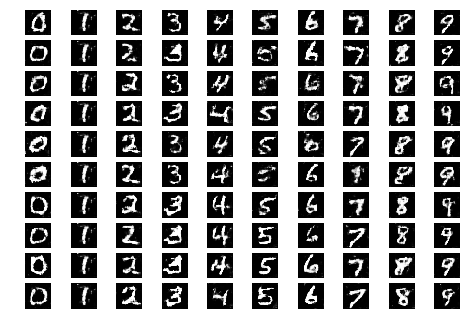

2401 [D loss: 1.693663, acc.: 40.62%, op_acc: 48.44%] [G loss: 1.694287]
2402 [D loss: 1.605105, acc.: 53.12%, op_acc: 45.31%] [G loss: 1.737476]
2403 [D loss: 1.714970, acc.: 64.06%, op_acc: 45.31%] [G loss: 1.713543]
2404 [D loss: 1.861620, acc.: 42.19%, op_acc: 29.69%] [G loss: 1.796754]
2405 [D loss: 1.701386, acc.: 57.81%, op_acc: 46.88%] [G loss: 1.684976]
2406 [D loss: 1.511803, acc.: 46.88%, op_acc: 59.38%] [G loss: 1.823590]
2407 [D loss: 1.548748, acc.: 50.00%, op_acc: 56.25%] [G loss: 1.771528]
2408 [D loss: 1.522749, acc.: 64.06%, op_acc: 60.94%] [G loss: 1.881719]
2409 [D loss: 1.661312, acc.: 37.50%, op_acc: 46.88%] [G loss: 1.655452]
2410 [D loss: 1.815623, acc.: 35.94%, op_acc: 39.06%] [G loss: 1.614137]
2411 [D loss: 1.846257, acc.: 53.12%, op_acc: 39.06%] [G loss: 1.845253]
2412 [D loss: 1.510042, acc.: 59.38%, op_acc: 54.69%] [G loss: 1.820891]
2413 [D loss: 1.700170, acc.: 51.56%, op_acc: 48.44%] [G loss: 1.812346]
2414 [D loss: 1.652081, acc.: 54.69%, op_acc: 46.88

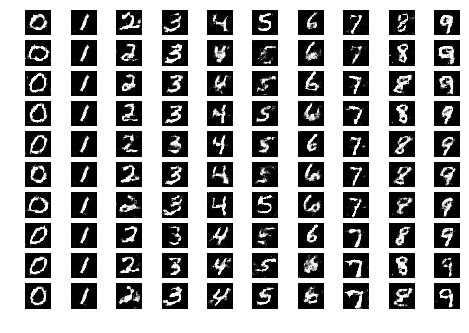

2601 [D loss: 1.528767, acc.: 65.62%, op_acc: 54.69%] [G loss: 1.647702]
2602 [D loss: 1.650117, acc.: 50.00%, op_acc: 48.44%] [G loss: 1.831294]
2603 [D loss: 1.541955, acc.: 46.88%, op_acc: 46.88%] [G loss: 1.738327]
2604 [D loss: 1.614240, acc.: 50.00%, op_acc: 51.56%] [G loss: 1.907274]
2605 [D loss: 1.680276, acc.: 53.12%, op_acc: 50.00%] [G loss: 1.586198]
2606 [D loss: 1.732185, acc.: 39.06%, op_acc: 39.06%] [G loss: 1.566360]
2607 [D loss: 1.740137, acc.: 53.12%, op_acc: 43.75%] [G loss: 1.716300]
2608 [D loss: 1.692147, acc.: 45.31%, op_acc: 46.88%] [G loss: 1.826798]
2609 [D loss: 1.688442, acc.: 40.62%, op_acc: 48.44%] [G loss: 1.625808]
2610 [D loss: 1.612979, acc.: 39.06%, op_acc: 48.44%] [G loss: 1.661563]
2611 [D loss: 1.572348, acc.: 46.88%, op_acc: 51.56%] [G loss: 1.561359]
2612 [D loss: 1.699077, acc.: 54.69%, op_acc: 39.06%] [G loss: 1.681885]
2613 [D loss: 1.588492, acc.: 59.38%, op_acc: 45.31%] [G loss: 1.746575]
2614 [D loss: 1.550107, acc.: 57.81%, op_acc: 48.44

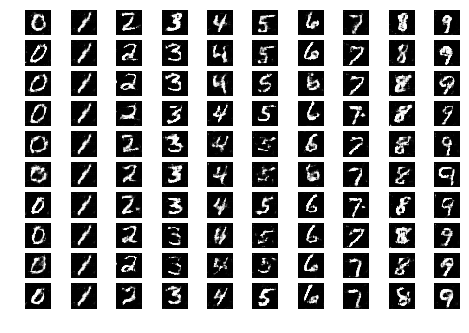

2801 [D loss: 1.658816, acc.: 50.00%, op_acc: 48.44%] [G loss: 1.795242]
2802 [D loss: 1.656474, acc.: 51.56%, op_acc: 46.88%] [G loss: 1.757904]
2803 [D loss: 1.677217, acc.: 50.00%, op_acc: 40.62%] [G loss: 1.793033]
2804 [D loss: 1.718364, acc.: 35.94%, op_acc: 54.69%] [G loss: 1.732062]
2805 [D loss: 1.652820, acc.: 53.12%, op_acc: 43.75%] [G loss: 1.858124]
2806 [D loss: 1.496523, acc.: 56.25%, op_acc: 57.81%] [G loss: 1.751446]
2807 [D loss: 1.538352, acc.: 46.88%, op_acc: 45.31%] [G loss: 1.818706]
2808 [D loss: 1.623706, acc.: 43.75%, op_acc: 53.12%] [G loss: 1.738199]
2809 [D loss: 1.759137, acc.: 51.56%, op_acc: 50.00%] [G loss: 1.791733]
2810 [D loss: 1.666541, acc.: 48.44%, op_acc: 45.31%] [G loss: 1.826388]
2811 [D loss: 1.637669, acc.: 54.69%, op_acc: 48.44%] [G loss: 1.620355]
2812 [D loss: 1.741958, acc.: 45.31%, op_acc: 43.75%] [G loss: 1.708743]
2813 [D loss: 1.670424, acc.: 50.00%, op_acc: 42.19%] [G loss: 1.604750]
2814 [D loss: 1.468982, acc.: 60.94%, op_acc: 48.44

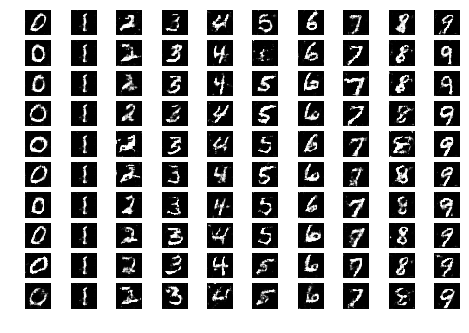

3001 [D loss: 1.625147, acc.: 46.88%, op_acc: 51.56%] [G loss: 1.791117]
3002 [D loss: 1.829054, acc.: 51.56%, op_acc: 37.50%] [G loss: 1.630458]
3003 [D loss: 1.472412, acc.: 57.81%, op_acc: 53.12%] [G loss: 1.905477]
3004 [D loss: 1.750148, acc.: 48.44%, op_acc: 48.44%] [G loss: 1.683116]
3005 [D loss: 1.718245, acc.: 50.00%, op_acc: 42.19%] [G loss: 1.761982]
3006 [D loss: 1.640942, acc.: 46.88%, op_acc: 40.62%] [G loss: 1.696681]
3007 [D loss: 1.648461, acc.: 59.38%, op_acc: 37.50%] [G loss: 1.647076]
3008 [D loss: 1.611025, acc.: 62.50%, op_acc: 40.62%] [G loss: 1.640598]
3009 [D loss: 1.597686, acc.: 53.12%, op_acc: 51.56%] [G loss: 1.808764]
3010 [D loss: 1.661232, acc.: 48.44%, op_acc: 42.19%] [G loss: 1.925546]
3011 [D loss: 1.680065, acc.: 53.12%, op_acc: 43.75%] [G loss: 1.844198]
3012 [D loss: 1.556930, acc.: 51.56%, op_acc: 45.31%] [G loss: 1.803292]
3013 [D loss: 1.725910, acc.: 51.56%, op_acc: 43.75%] [G loss: 1.783917]
3014 [D loss: 1.693033, acc.: 60.94%, op_acc: 37.50

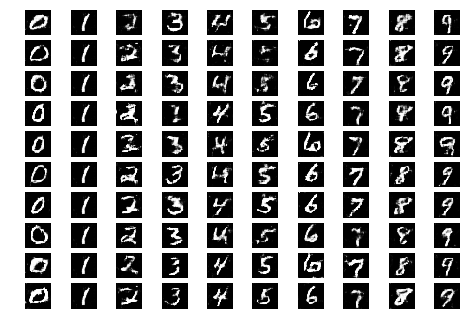

3201 [D loss: 1.675000, acc.: 46.88%, op_acc: 42.19%] [G loss: 1.734034]
3202 [D loss: 1.654247, acc.: 57.81%, op_acc: 50.00%] [G loss: 1.799295]
3203 [D loss: 1.629421, acc.: 57.81%, op_acc: 37.50%] [G loss: 1.522800]
3204 [D loss: 1.742652, acc.: 46.88%, op_acc: 43.75%] [G loss: 1.623985]
3205 [D loss: 1.656636, acc.: 42.19%, op_acc: 50.00%] [G loss: 1.676522]
3206 [D loss: 1.636773, acc.: 45.31%, op_acc: 50.00%] [G loss: 1.626983]
3207 [D loss: 1.554148, acc.: 50.00%, op_acc: 50.00%] [G loss: 1.873464]
3208 [D loss: 1.681528, acc.: 53.12%, op_acc: 50.00%] [G loss: 1.693277]
3209 [D loss: 1.846194, acc.: 56.25%, op_acc: 43.75%] [G loss: 1.788523]
3210 [D loss: 1.504160, acc.: 51.56%, op_acc: 56.25%] [G loss: 1.725914]
3211 [D loss: 1.645205, acc.: 45.31%, op_acc: 48.44%] [G loss: 1.791029]
3212 [D loss: 1.603817, acc.: 57.81%, op_acc: 43.75%] [G loss: 1.677014]
3213 [D loss: 1.632061, acc.: 50.00%, op_acc: 51.56%] [G loss: 1.590296]
3214 [D loss: 1.739901, acc.: 43.75%, op_acc: 48.44

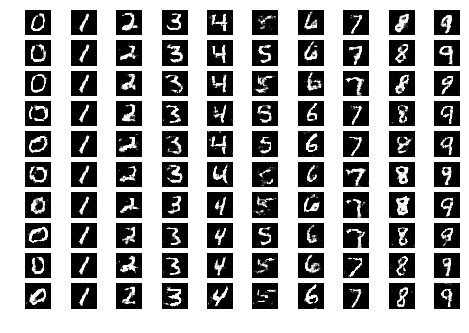

3401 [D loss: 1.530240, acc.: 60.94%, op_acc: 43.75%] [G loss: 1.726736]
3402 [D loss: 1.621572, acc.: 56.25%, op_acc: 45.31%] [G loss: 1.867921]
3403 [D loss: 1.711189, acc.: 50.00%, op_acc: 40.62%] [G loss: 1.657974]
3404 [D loss: 1.727918, acc.: 50.00%, op_acc: 34.38%] [G loss: 1.554674]
3405 [D loss: 1.664963, acc.: 42.19%, op_acc: 37.50%] [G loss: 1.504555]
3406 [D loss: 1.665245, acc.: 46.88%, op_acc: 40.62%] [G loss: 1.693607]
3407 [D loss: 1.623894, acc.: 54.69%, op_acc: 48.44%] [G loss: 1.763983]
3408 [D loss: 1.512060, acc.: 54.69%, op_acc: 42.19%] [G loss: 1.569452]
3409 [D loss: 1.625865, acc.: 59.38%, op_acc: 48.44%] [G loss: 1.784861]
3410 [D loss: 1.648136, acc.: 45.31%, op_acc: 40.62%] [G loss: 1.484177]
3411 [D loss: 1.680548, acc.: 53.12%, op_acc: 34.38%] [G loss: 1.561571]
3412 [D loss: 1.626796, acc.: 53.12%, op_acc: 48.44%] [G loss: 1.789149]
3413 [D loss: 1.787926, acc.: 50.00%, op_acc: 34.38%] [G loss: 1.752685]
3414 [D loss: 1.672112, acc.: 45.31%, op_acc: 42.19

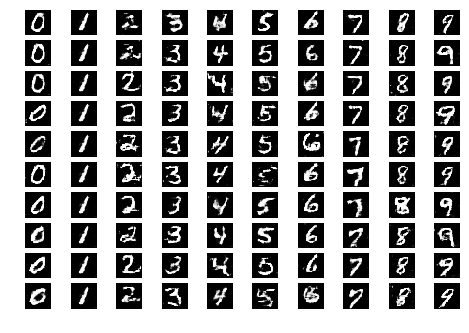

3601 [D loss: 1.659453, acc.: 54.69%, op_acc: 40.62%] [G loss: 1.576427]
3602 [D loss: 1.599535, acc.: 45.31%, op_acc: 48.44%] [G loss: 1.715853]
3603 [D loss: 1.483442, acc.: 51.56%, op_acc: 48.44%] [G loss: 1.611935]
3604 [D loss: 1.678050, acc.: 53.12%, op_acc: 34.38%] [G loss: 1.792845]
3605 [D loss: 1.625573, acc.: 46.88%, op_acc: 50.00%] [G loss: 1.791429]
3606 [D loss: 1.619670, acc.: 48.44%, op_acc: 42.19%] [G loss: 1.665634]
3607 [D loss: 1.533572, acc.: 57.81%, op_acc: 46.88%] [G loss: 1.653221]
3608 [D loss: 1.487185, acc.: 50.00%, op_acc: 57.81%] [G loss: 1.647668]
3609 [D loss: 1.571433, acc.: 51.56%, op_acc: 43.75%] [G loss: 1.602382]
3610 [D loss: 1.712224, acc.: 53.12%, op_acc: 39.06%] [G loss: 1.652320]
3611 [D loss: 1.528415, acc.: 57.81%, op_acc: 54.69%] [G loss: 1.583623]
3612 [D loss: 1.628509, acc.: 46.88%, op_acc: 54.69%] [G loss: 1.809984]
3613 [D loss: 1.592230, acc.: 56.25%, op_acc: 46.88%] [G loss: 1.695963]
3614 [D loss: 1.727688, acc.: 39.06%, op_acc: 35.94

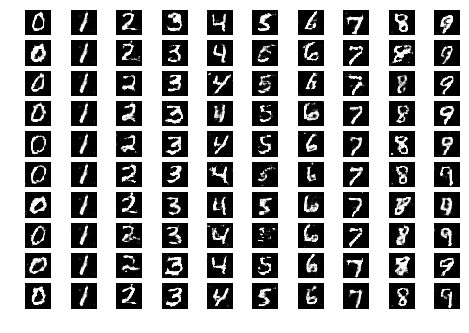

3801 [D loss: 1.713901, acc.: 53.12%, op_acc: 39.06%] [G loss: 1.785192]
3802 [D loss: 1.626891, acc.: 56.25%, op_acc: 51.56%] [G loss: 1.718287]
3803 [D loss: 1.622430, acc.: 48.44%, op_acc: 50.00%] [G loss: 1.615862]
3804 [D loss: 1.679508, acc.: 54.69%, op_acc: 37.50%] [G loss: 1.604965]
3805 [D loss: 1.593989, acc.: 45.31%, op_acc: 48.44%] [G loss: 1.748640]
3806 [D loss: 1.647160, acc.: 53.12%, op_acc: 56.25%] [G loss: 1.571388]
3807 [D loss: 1.695191, acc.: 42.19%, op_acc: 53.12%] [G loss: 1.598844]
3808 [D loss: 1.518918, acc.: 62.50%, op_acc: 48.44%] [G loss: 1.745253]
3809 [D loss: 1.539844, acc.: 59.38%, op_acc: 48.44%] [G loss: 1.716121]
3810 [D loss: 1.552410, acc.: 53.12%, op_acc: 53.12%] [G loss: 1.664829]
3811 [D loss: 1.448049, acc.: 62.50%, op_acc: 57.81%] [G loss: 1.788417]
3812 [D loss: 1.623733, acc.: 53.12%, op_acc: 39.06%] [G loss: 1.665332]
3813 [D loss: 1.685847, acc.: 59.38%, op_acc: 39.06%] [G loss: 1.624732]
3814 [D loss: 1.502082, acc.: 46.88%, op_acc: 57.81

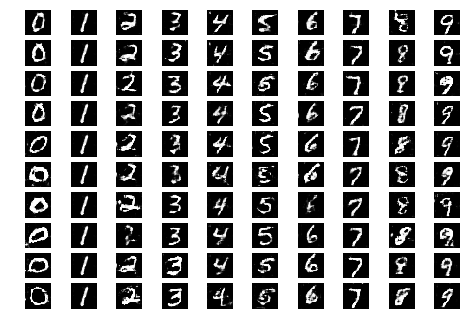

4001 [D loss: 1.522171, acc.: 56.25%, op_acc: 51.56%] [G loss: 1.682280]
4002 [D loss: 1.573678, acc.: 54.69%, op_acc: 46.88%] [G loss: 1.670327]
4003 [D loss: 1.572981, acc.: 57.81%, op_acc: 43.75%] [G loss: 1.552133]
4004 [D loss: 1.530650, acc.: 62.50%, op_acc: 50.00%] [G loss: 1.742716]
4005 [D loss: 1.438529, acc.: 59.38%, op_acc: 60.94%] [G loss: 1.673600]
4006 [D loss: 1.706897, acc.: 53.12%, op_acc: 46.88%] [G loss: 1.695027]
4007 [D loss: 1.689340, acc.: 59.38%, op_acc: 46.88%] [G loss: 1.696144]
4008 [D loss: 1.621670, acc.: 45.31%, op_acc: 42.19%] [G loss: 1.569255]
4009 [D loss: 1.584106, acc.: 39.06%, op_acc: 50.00%] [G loss: 1.760288]
4010 [D loss: 1.555407, acc.: 45.31%, op_acc: 53.12%] [G loss: 1.666319]
4011 [D loss: 1.593538, acc.: 51.56%, op_acc: 39.06%] [G loss: 1.823962]
4012 [D loss: 1.710775, acc.: 46.88%, op_acc: 42.19%] [G loss: 1.560961]
4013 [D loss: 1.807776, acc.: 50.00%, op_acc: 35.94%] [G loss: 1.671923]
4014 [D loss: 1.673403, acc.: 62.50%, op_acc: 39.06

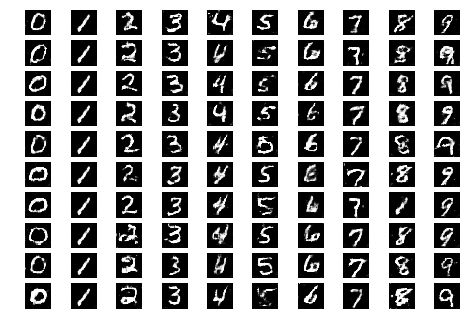

4201 [D loss: 1.863605, acc.: 42.19%, op_acc: 31.25%] [G loss: 1.489329]
4202 [D loss: 1.570339, acc.: 64.06%, op_acc: 37.50%] [G loss: 1.566146]
4203 [D loss: 1.622605, acc.: 46.88%, op_acc: 45.31%] [G loss: 1.581606]
4204 [D loss: 1.449232, acc.: 53.12%, op_acc: 54.69%] [G loss: 1.619879]
4205 [D loss: 1.483829, acc.: 65.62%, op_acc: 51.56%] [G loss: 1.648412]
4206 [D loss: 1.618383, acc.: 53.12%, op_acc: 46.88%] [G loss: 1.579868]
4207 [D loss: 1.644750, acc.: 59.38%, op_acc: 46.88%] [G loss: 1.620690]
4208 [D loss: 1.603641, acc.: 56.25%, op_acc: 46.88%] [G loss: 1.745730]
4209 [D loss: 1.554844, acc.: 57.81%, op_acc: 48.44%] [G loss: 1.644141]
4210 [D loss: 1.523074, acc.: 60.94%, op_acc: 51.56%] [G loss: 1.638335]
4211 [D loss: 1.609843, acc.: 51.56%, op_acc: 40.62%] [G loss: 1.616332]
4212 [D loss: 1.722665, acc.: 43.75%, op_acc: 32.81%] [G loss: 1.439683]
4213 [D loss: 1.572107, acc.: 50.00%, op_acc: 53.12%] [G loss: 1.623376]
4214 [D loss: 1.544402, acc.: 48.44%, op_acc: 62.50

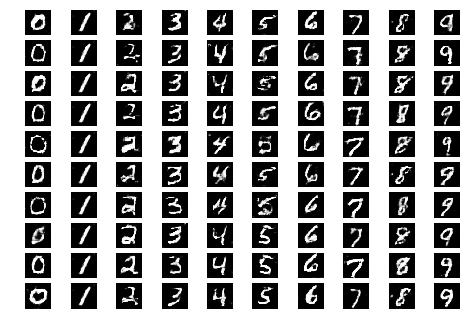

4401 [D loss: 1.857356, acc.: 53.12%, op_acc: 26.56%] [G loss: 1.573825]
4402 [D loss: 1.569530, acc.: 64.06%, op_acc: 46.88%] [G loss: 1.583423]
4403 [D loss: 1.636399, acc.: 50.00%, op_acc: 43.75%] [G loss: 1.710945]
4404 [D loss: 1.622082, acc.: 56.25%, op_acc: 45.31%] [G loss: 1.600838]
4405 [D loss: 1.588565, acc.: 46.88%, op_acc: 54.69%] [G loss: 1.491547]
4406 [D loss: 1.658963, acc.: 46.88%, op_acc: 43.75%] [G loss: 1.643628]
4407 [D loss: 1.700245, acc.: 57.81%, op_acc: 37.50%] [G loss: 1.715500]
4408 [D loss: 1.724488, acc.: 48.44%, op_acc: 42.19%] [G loss: 1.658053]
4409 [D loss: 1.652629, acc.: 42.19%, op_acc: 39.06%] [G loss: 1.568756]
4410 [D loss: 1.553520, acc.: 43.75%, op_acc: 46.88%] [G loss: 1.810650]
4411 [D loss: 1.637637, acc.: 51.56%, op_acc: 43.75%] [G loss: 1.765034]
4412 [D loss: 1.642193, acc.: 46.88%, op_acc: 45.31%] [G loss: 1.609918]
4413 [D loss: 1.639432, acc.: 62.50%, op_acc: 39.06%] [G loss: 1.683218]
4414 [D loss: 1.640659, acc.: 43.75%, op_acc: 39.06

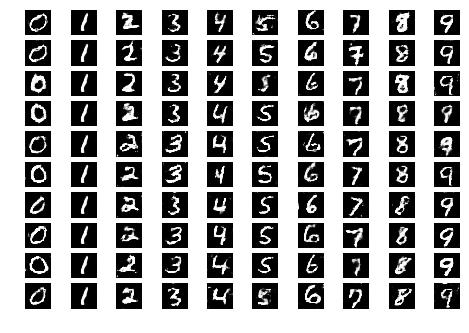

4601 [D loss: 1.533103, acc.: 54.69%, op_acc: 42.19%] [G loss: 1.731028]
4602 [D loss: 1.665726, acc.: 54.69%, op_acc: 40.62%] [G loss: 1.708820]
4603 [D loss: 1.645084, acc.: 43.75%, op_acc: 40.62%] [G loss: 1.658824]
4604 [D loss: 1.604381, acc.: 50.00%, op_acc: 43.75%] [G loss: 1.647283]
4605 [D loss: 1.679753, acc.: 40.62%, op_acc: 40.62%] [G loss: 1.525118]
4606 [D loss: 1.650360, acc.: 51.56%, op_acc: 43.75%] [G loss: 1.759581]
4607 [D loss: 1.515976, acc.: 64.06%, op_acc: 42.19%] [G loss: 1.689161]
4608 [D loss: 1.517743, acc.: 57.81%, op_acc: 46.88%] [G loss: 1.618924]
4609 [D loss: 1.576628, acc.: 57.81%, op_acc: 43.75%] [G loss: 1.586510]
4610 [D loss: 1.603782, acc.: 56.25%, op_acc: 35.94%] [G loss: 1.639495]
4611 [D loss: 1.570640, acc.: 51.56%, op_acc: 46.88%] [G loss: 1.556772]
4612 [D loss: 1.645562, acc.: 42.19%, op_acc: 39.06%] [G loss: 1.492951]
4613 [D loss: 1.669792, acc.: 56.25%, op_acc: 40.62%] [G loss: 1.678794]
4614 [D loss: 1.617776, acc.: 40.62%, op_acc: 45.31

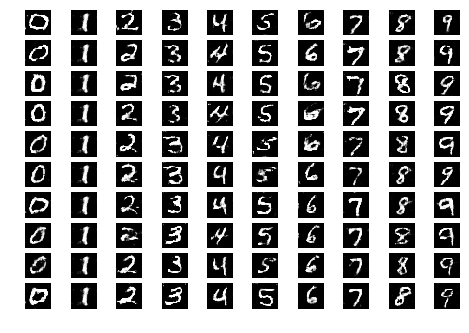

4801 [D loss: 1.577452, acc.: 46.88%, op_acc: 45.31%] [G loss: 1.746417]
4802 [D loss: 1.578175, acc.: 62.50%, op_acc: 40.62%] [G loss: 1.521123]
4803 [D loss: 1.558469, acc.: 57.81%, op_acc: 37.50%] [G loss: 1.611409]
4804 [D loss: 1.612372, acc.: 60.94%, op_acc: 43.75%] [G loss: 1.597898]
4805 [D loss: 1.584955, acc.: 48.44%, op_acc: 50.00%] [G loss: 1.508707]
4806 [D loss: 1.709479, acc.: 51.56%, op_acc: 37.50%] [G loss: 1.770737]
4807 [D loss: 1.663300, acc.: 43.75%, op_acc: 39.06%] [G loss: 1.623027]
4808 [D loss: 1.573264, acc.: 48.44%, op_acc: 56.25%] [G loss: 1.809957]
4809 [D loss: 1.636994, acc.: 43.75%, op_acc: 39.06%] [G loss: 1.727423]
4810 [D loss: 1.742193, acc.: 51.56%, op_acc: 40.62%] [G loss: 1.658921]
4811 [D loss: 1.546457, acc.: 45.31%, op_acc: 45.31%] [G loss: 1.778138]
4812 [D loss: 1.759507, acc.: 56.25%, op_acc: 35.94%] [G loss: 1.514489]
4813 [D loss: 1.618409, acc.: 45.31%, op_acc: 54.69%] [G loss: 1.611109]
4814 [D loss: 1.586603, acc.: 54.69%, op_acc: 43.75

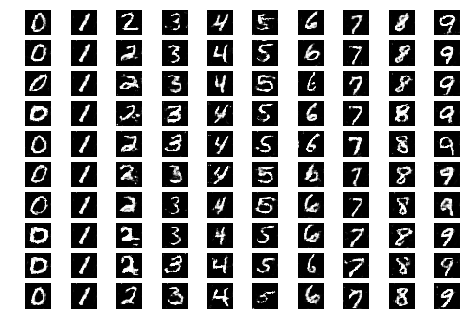

5001 [D loss: 1.596092, acc.: 53.12%, op_acc: 37.50%] [G loss: 1.412474]
5002 [D loss: 1.659606, acc.: 50.00%, op_acc: 50.00%] [G loss: 1.599702]
5003 [D loss: 1.490461, acc.: 68.75%, op_acc: 53.12%] [G loss: 1.427119]
5004 [D loss: 1.539600, acc.: 53.12%, op_acc: 50.00%] [G loss: 1.614205]
5005 [D loss: 1.741659, acc.: 45.31%, op_acc: 39.06%] [G loss: 1.494609]
5006 [D loss: 1.612213, acc.: 54.69%, op_acc: 54.69%] [G loss: 1.680740]
5007 [D loss: 1.517534, acc.: 51.56%, op_acc: 50.00%] [G loss: 1.502465]
5008 [D loss: 1.637406, acc.: 54.69%, op_acc: 46.88%] [G loss: 1.596555]
5009 [D loss: 1.552595, acc.: 53.12%, op_acc: 48.44%] [G loss: 1.625875]
5010 [D loss: 1.526963, acc.: 53.12%, op_acc: 43.75%] [G loss: 1.582733]
5011 [D loss: 1.565885, acc.: 50.00%, op_acc: 43.75%] [G loss: 1.585153]
5012 [D loss: 1.621531, acc.: 39.06%, op_acc: 43.75%] [G loss: 1.570157]
5013 [D loss: 1.597886, acc.: 45.31%, op_acc: 42.19%] [G loss: 1.607912]
5014 [D loss: 1.646331, acc.: 51.56%, op_acc: 48.44

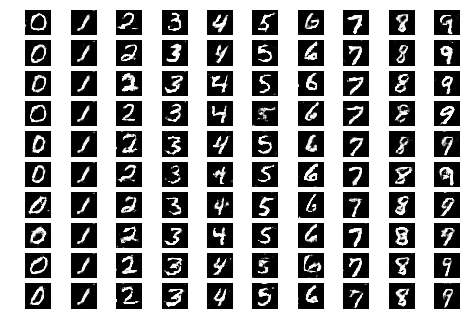

5201 [D loss: 1.454880, acc.: 46.88%, op_acc: 53.12%] [G loss: 1.611123]
5202 [D loss: 1.610101, acc.: 42.19%, op_acc: 43.75%] [G loss: 1.470900]
5203 [D loss: 1.616900, acc.: 64.06%, op_acc: 48.44%] [G loss: 1.609746]
5204 [D loss: 1.621769, acc.: 45.31%, op_acc: 40.62%] [G loss: 1.580786]
5205 [D loss: 1.651852, acc.: 35.94%, op_acc: 40.62%] [G loss: 1.530006]
5206 [D loss: 1.588133, acc.: 54.69%, op_acc: 48.44%] [G loss: 1.581478]
5207 [D loss: 1.587913, acc.: 46.88%, op_acc: 34.38%] [G loss: 1.546277]
5208 [D loss: 1.525511, acc.: 50.00%, op_acc: 48.44%] [G loss: 1.621477]
5209 [D loss: 1.549027, acc.: 46.88%, op_acc: 43.75%] [G loss: 1.622260]
5210 [D loss: 1.536998, acc.: 50.00%, op_acc: 48.44%] [G loss: 1.683273]
5211 [D loss: 1.596803, acc.: 51.56%, op_acc: 54.69%] [G loss: 1.782683]
5212 [D loss: 1.601160, acc.: 56.25%, op_acc: 42.19%] [G loss: 1.585723]
5213 [D loss: 1.751154, acc.: 45.31%, op_acc: 29.69%] [G loss: 1.598751]
5214 [D loss: 1.488916, acc.: 64.06%, op_acc: 45.31

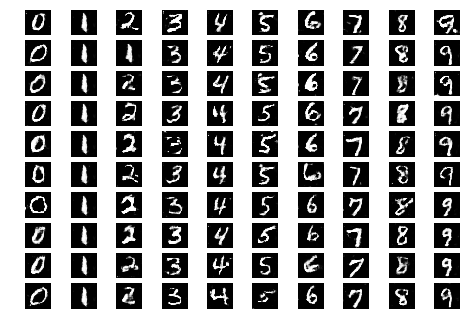

5401 [D loss: 1.552805, acc.: 48.44%, op_acc: 51.56%] [G loss: 1.724300]
5402 [D loss: 1.592814, acc.: 40.62%, op_acc: 53.12%] [G loss: 1.607647]
5403 [D loss: 1.565037, acc.: 48.44%, op_acc: 48.44%] [G loss: 1.575572]
5404 [D loss: 1.558017, acc.: 50.00%, op_acc: 51.56%] [G loss: 1.565566]
5405 [D loss: 1.527728, acc.: 45.31%, op_acc: 51.56%] [G loss: 1.593430]
5406 [D loss: 1.601567, acc.: 53.12%, op_acc: 39.06%] [G loss: 1.575164]
5407 [D loss: 1.553570, acc.: 48.44%, op_acc: 46.88%] [G loss: 1.820837]
5408 [D loss: 1.640990, acc.: 56.25%, op_acc: 37.50%] [G loss: 1.577809]
5409 [D loss: 1.518703, acc.: 46.88%, op_acc: 48.44%] [G loss: 1.644679]
5410 [D loss: 1.705464, acc.: 53.12%, op_acc: 35.94%] [G loss: 1.605292]
5411 [D loss: 1.700107, acc.: 46.88%, op_acc: 45.31%] [G loss: 1.761472]
5412 [D loss: 1.492021, acc.: 57.81%, op_acc: 54.69%] [G loss: 1.698180]
5413 [D loss: 1.723867, acc.: 50.00%, op_acc: 40.62%] [G loss: 1.703065]
5414 [D loss: 1.568714, acc.: 51.56%, op_acc: 48.44

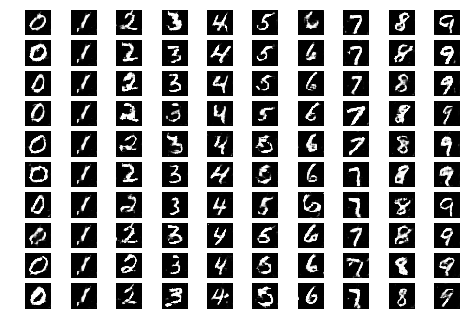

5601 [D loss: 1.565407, acc.: 39.06%, op_acc: 51.56%] [G loss: 1.567409]
5602 [D loss: 1.605950, acc.: 40.62%, op_acc: 45.31%] [G loss: 1.599416]
5603 [D loss: 1.531303, acc.: 54.69%, op_acc: 46.88%] [G loss: 1.510175]
5604 [D loss: 1.621037, acc.: 40.62%, op_acc: 48.44%] [G loss: 1.477658]
5605 [D loss: 1.740536, acc.: 39.06%, op_acc: 46.88%] [G loss: 1.785486]
5606 [D loss: 1.628388, acc.: 42.19%, op_acc: 51.56%] [G loss: 1.432567]
5607 [D loss: 1.613343, acc.: 56.25%, op_acc: 40.62%] [G loss: 1.568028]
5608 [D loss: 1.603613, acc.: 45.31%, op_acc: 53.12%] [G loss: 1.516084]
5609 [D loss: 1.657337, acc.: 50.00%, op_acc: 34.38%] [G loss: 1.359009]
5610 [D loss: 1.535679, acc.: 54.69%, op_acc: 53.12%] [G loss: 1.596686]
5611 [D loss: 1.465849, acc.: 53.12%, op_acc: 54.69%] [G loss: 1.635635]
5612 [D loss: 1.581639, acc.: 50.00%, op_acc: 53.12%] [G loss: 1.718086]
5613 [D loss: 1.634990, acc.: 42.19%, op_acc: 37.50%] [G loss: 1.605239]
5614 [D loss: 1.639565, acc.: 53.12%, op_acc: 42.19

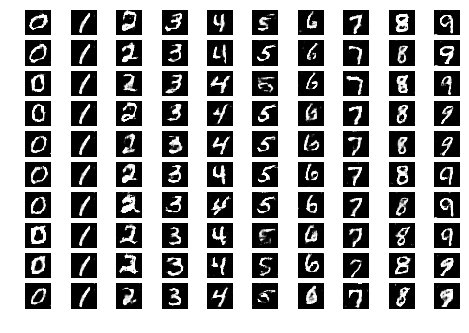

5801 [D loss: 1.690543, acc.: 54.69%, op_acc: 40.62%] [G loss: 1.671478]
5802 [D loss: 1.589459, acc.: 50.00%, op_acc: 40.62%] [G loss: 1.695329]
5803 [D loss: 1.521528, acc.: 50.00%, op_acc: 46.88%] [G loss: 1.526625]
5804 [D loss: 1.596176, acc.: 53.12%, op_acc: 43.75%] [G loss: 1.622106]
5805 [D loss: 1.532599, acc.: 51.56%, op_acc: 51.56%] [G loss: 1.637514]
5806 [D loss: 1.584061, acc.: 50.00%, op_acc: 39.06%] [G loss: 1.570945]
5807 [D loss: 1.506589, acc.: 50.00%, op_acc: 48.44%] [G loss: 1.597590]
5808 [D loss: 1.519229, acc.: 57.81%, op_acc: 51.56%] [G loss: 1.767322]
5809 [D loss: 1.588438, acc.: 48.44%, op_acc: 43.75%] [G loss: 1.672935]
5810 [D loss: 1.521305, acc.: 53.12%, op_acc: 48.44%] [G loss: 1.839308]
5811 [D loss: 1.570787, acc.: 53.12%, op_acc: 45.31%] [G loss: 1.777168]
5812 [D loss: 1.524585, acc.: 57.81%, op_acc: 48.44%] [G loss: 1.560782]
5813 [D loss: 1.529553, acc.: 51.56%, op_acc: 54.69%] [G loss: 1.655073]
5814 [D loss: 1.604666, acc.: 45.31%, op_acc: 46.88

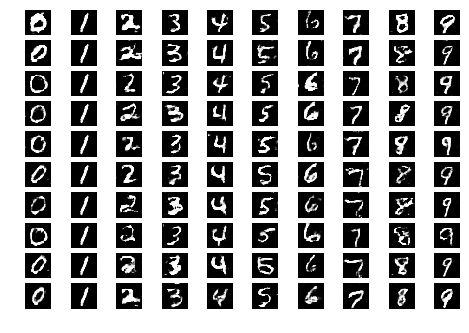

6001 [D loss: 1.558924, acc.: 48.44%, op_acc: 53.12%] [G loss: 1.898801]
6002 [D loss: 1.580681, acc.: 43.75%, op_acc: 45.31%] [G loss: 1.744317]
6003 [D loss: 1.521189, acc.: 53.12%, op_acc: 54.69%] [G loss: 1.682465]
6004 [D loss: 1.565425, acc.: 46.88%, op_acc: 51.56%] [G loss: 1.731475]
6005 [D loss: 1.443501, acc.: 54.69%, op_acc: 57.81%] [G loss: 1.773866]
6006 [D loss: 1.594385, acc.: 57.81%, op_acc: 43.75%] [G loss: 1.554857]
6007 [D loss: 1.453239, acc.: 45.31%, op_acc: 48.44%] [G loss: 1.580552]
6008 [D loss: 1.532414, acc.: 46.88%, op_acc: 46.88%] [G loss: 1.652240]
6009 [D loss: 1.537886, acc.: 46.88%, op_acc: 42.19%] [G loss: 1.522760]
6010 [D loss: 1.636312, acc.: 42.19%, op_acc: 39.06%] [G loss: 1.597885]
6011 [D loss: 1.606274, acc.: 56.25%, op_acc: 48.44%] [G loss: 1.564818]
6012 [D loss: 1.587686, acc.: 43.75%, op_acc: 45.31%] [G loss: 1.537410]
6013 [D loss: 1.557591, acc.: 42.19%, op_acc: 50.00%] [G loss: 1.424774]
6014 [D loss: 1.536960, acc.: 54.69%, op_acc: 46.88

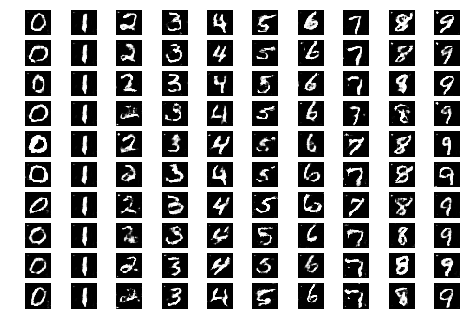

6201 [D loss: 1.576126, acc.: 43.75%, op_acc: 45.31%] [G loss: 1.670854]
6202 [D loss: 1.584570, acc.: 48.44%, op_acc: 48.44%] [G loss: 1.591162]
6203 [D loss: 1.550999, acc.: 56.25%, op_acc: 57.81%] [G loss: 1.636033]
6204 [D loss: 1.480940, acc.: 56.25%, op_acc: 48.44%] [G loss: 1.592377]
6205 [D loss: 1.545083, acc.: 51.56%, op_acc: 48.44%] [G loss: 1.660034]
6206 [D loss: 1.538363, acc.: 56.25%, op_acc: 46.88%] [G loss: 1.707003]
6207 [D loss: 1.558918, acc.: 57.81%, op_acc: 45.31%] [G loss: 1.802496]
6208 [D loss: 1.561602, acc.: 64.06%, op_acc: 51.56%] [G loss: 1.655239]
6209 [D loss: 1.627177, acc.: 42.19%, op_acc: 46.88%] [G loss: 1.562853]
6210 [D loss: 1.496050, acc.: 56.25%, op_acc: 50.00%] [G loss: 1.592011]
6211 [D loss: 1.398052, acc.: 62.50%, op_acc: 64.06%] [G loss: 1.634631]
6212 [D loss: 1.726160, acc.: 53.12%, op_acc: 34.38%] [G loss: 1.584272]
6213 [D loss: 1.599244, acc.: 71.88%, op_acc: 42.19%] [G loss: 1.576436]
6214 [D loss: 1.579452, acc.: 46.88%, op_acc: 43.75

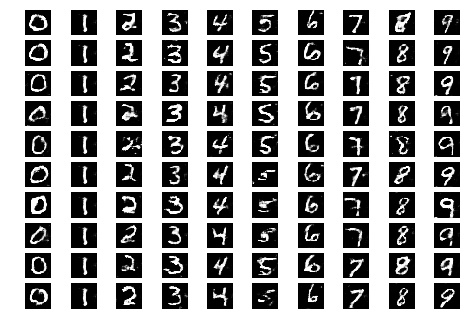

6401 [D loss: 1.616858, acc.: 60.94%, op_acc: 43.75%] [G loss: 1.550376]
6402 [D loss: 1.421788, acc.: 56.25%, op_acc: 57.81%] [G loss: 1.631457]
6403 [D loss: 1.494953, acc.: 42.19%, op_acc: 59.38%] [G loss: 1.573141]
6404 [D loss: 1.458428, acc.: 62.50%, op_acc: 39.06%] [G loss: 1.770869]
6405 [D loss: 1.574983, acc.: 51.56%, op_acc: 50.00%] [G loss: 1.622318]
6406 [D loss: 1.515623, acc.: 56.25%, op_acc: 43.75%] [G loss: 1.556953]
6407 [D loss: 1.597539, acc.: 46.88%, op_acc: 45.31%] [G loss: 1.652829]
6408 [D loss: 1.716725, acc.: 48.44%, op_acc: 40.62%] [G loss: 1.500337]
6409 [D loss: 1.641263, acc.: 57.81%, op_acc: 40.62%] [G loss: 1.579351]
6410 [D loss: 1.527174, acc.: 50.00%, op_acc: 46.88%] [G loss: 1.707735]
6411 [D loss: 1.649053, acc.: 40.62%, op_acc: 43.75%] [G loss: 1.609156]
6412 [D loss: 1.729520, acc.: 51.56%, op_acc: 31.25%] [G loss: 1.485035]
6413 [D loss: 1.516208, acc.: 37.50%, op_acc: 43.75%] [G loss: 1.516954]
6414 [D loss: 1.779772, acc.: 32.81%, op_acc: 31.25

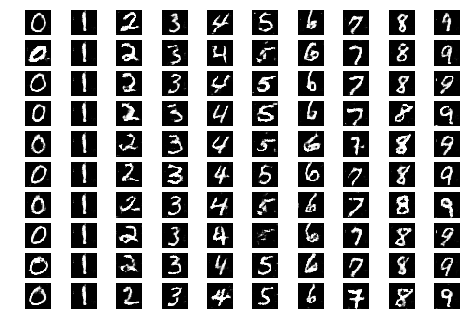

6601 [D loss: 1.545473, acc.: 42.19%, op_acc: 43.75%] [G loss: 1.571099]
6602 [D loss: 1.609640, acc.: 50.00%, op_acc: 39.06%] [G loss: 1.618276]
6603 [D loss: 1.862541, acc.: 53.12%, op_acc: 34.38%] [G loss: 1.630601]
6604 [D loss: 1.508806, acc.: 42.19%, op_acc: 48.44%] [G loss: 1.525327]
6605 [D loss: 1.562432, acc.: 60.94%, op_acc: 40.62%] [G loss: 1.625735]
6606 [D loss: 1.681479, acc.: 51.56%, op_acc: 46.88%] [G loss: 1.617300]
6607 [D loss: 1.560856, acc.: 57.81%, op_acc: 50.00%] [G loss: 1.629426]
6608 [D loss: 1.416369, acc.: 53.12%, op_acc: 59.38%] [G loss: 1.723373]
6609 [D loss: 1.625731, acc.: 39.06%, op_acc: 45.31%] [G loss: 1.593371]
6610 [D loss: 1.467078, acc.: 53.12%, op_acc: 56.25%] [G loss: 1.701095]
6611 [D loss: 1.640633, acc.: 45.31%, op_acc: 39.06%] [G loss: 1.690326]
6612 [D loss: 1.418580, acc.: 56.25%, op_acc: 54.69%] [G loss: 1.626799]
6613 [D loss: 1.534898, acc.: 50.00%, op_acc: 51.56%] [G loss: 1.558151]
6614 [D loss: 1.590331, acc.: 54.69%, op_acc: 40.62

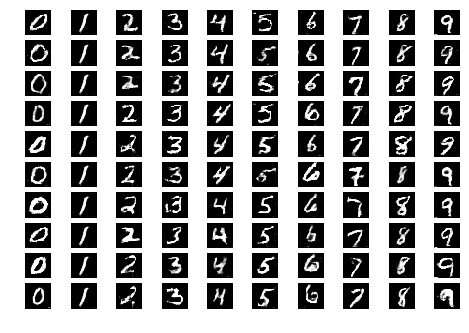

6801 [D loss: 1.462940, acc.: 57.81%, op_acc: 50.00%] [G loss: 1.645317]
6802 [D loss: 1.586277, acc.: 45.31%, op_acc: 39.06%] [G loss: 1.682023]
6803 [D loss: 1.641061, acc.: 42.19%, op_acc: 39.06%] [G loss: 1.432152]
6804 [D loss: 1.609318, acc.: 56.25%, op_acc: 37.50%] [G loss: 1.725279]
6805 [D loss: 1.495108, acc.: 59.38%, op_acc: 56.25%] [G loss: 1.629011]
6806 [D loss: 1.595669, acc.: 40.62%, op_acc: 48.44%] [G loss: 1.601993]
6807 [D loss: 1.525436, acc.: 60.94%, op_acc: 50.00%] [G loss: 1.638200]
6808 [D loss: 1.593966, acc.: 45.31%, op_acc: 35.94%] [G loss: 1.578963]
6809 [D loss: 1.523930, acc.: 60.94%, op_acc: 51.56%] [G loss: 1.667343]
6810 [D loss: 1.581468, acc.: 50.00%, op_acc: 43.75%] [G loss: 1.758005]
6811 [D loss: 1.566976, acc.: 53.12%, op_acc: 37.50%] [G loss: 1.651998]
6812 [D loss: 1.575355, acc.: 45.31%, op_acc: 46.88%] [G loss: 1.593702]
6813 [D loss: 1.530405, acc.: 53.12%, op_acc: 50.00%] [G loss: 1.624456]
6814 [D loss: 1.465289, acc.: 48.44%, op_acc: 59.38

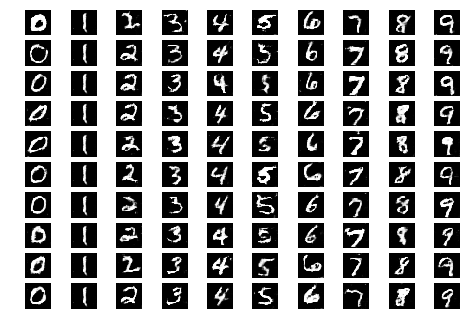

7001 [D loss: 1.610118, acc.: 46.88%, op_acc: 45.31%] [G loss: 1.745860]
7002 [D loss: 1.476193, acc.: 59.38%, op_acc: 51.56%] [G loss: 1.594422]
7003 [D loss: 1.488625, acc.: 59.38%, op_acc: 48.44%] [G loss: 1.647646]
7004 [D loss: 1.586931, acc.: 54.69%, op_acc: 50.00%] [G loss: 1.669760]
7005 [D loss: 1.527018, acc.: 53.12%, op_acc: 43.75%] [G loss: 1.735577]
7006 [D loss: 1.565224, acc.: 54.69%, op_acc: 56.25%] [G loss: 1.663296]
7007 [D loss: 1.520780, acc.: 46.88%, op_acc: 48.44%] [G loss: 1.467161]
7008 [D loss: 1.537974, acc.: 46.88%, op_acc: 43.75%] [G loss: 1.589099]
7009 [D loss: 1.550136, acc.: 50.00%, op_acc: 37.50%] [G loss: 1.619994]
7010 [D loss: 1.579229, acc.: 54.69%, op_acc: 51.56%] [G loss: 1.637571]
7011 [D loss: 1.573081, acc.: 60.94%, op_acc: 46.88%] [G loss: 1.856752]
7012 [D loss: 1.424955, acc.: 76.56%, op_acc: 50.00%] [G loss: 1.833935]
7013 [D loss: 1.555905, acc.: 50.00%, op_acc: 45.31%] [G loss: 1.605046]
7014 [D loss: 1.590045, acc.: 50.00%, op_acc: 45.31

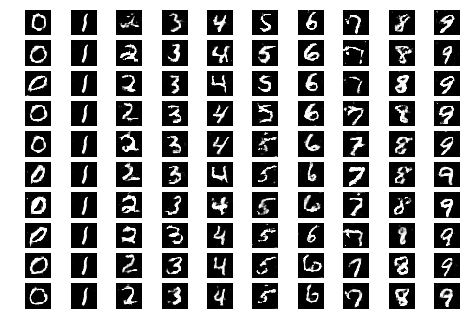

7201 [D loss: 1.634221, acc.: 48.44%, op_acc: 43.75%] [G loss: 1.729169]
7202 [D loss: 1.702154, acc.: 50.00%, op_acc: 40.62%] [G loss: 1.618316]
7203 [D loss: 1.525146, acc.: 39.06%, op_acc: 53.12%] [G loss: 1.678198]
7204 [D loss: 1.548356, acc.: 45.31%, op_acc: 48.44%] [G loss: 1.551540]
7205 [D loss: 1.486183, acc.: 53.12%, op_acc: 39.06%] [G loss: 1.593991]
7206 [D loss: 1.588516, acc.: 35.94%, op_acc: 45.31%] [G loss: 1.615832]
7207 [D loss: 1.628764, acc.: 45.31%, op_acc: 40.62%] [G loss: 1.605411]
7208 [D loss: 1.637280, acc.: 46.88%, op_acc: 48.44%] [G loss: 1.678486]
7209 [D loss: 1.517103, acc.: 62.50%, op_acc: 53.12%] [G loss: 1.623710]
7210 [D loss: 1.553705, acc.: 53.12%, op_acc: 51.56%] [G loss: 1.668257]
7211 [D loss: 1.694813, acc.: 40.62%, op_acc: 35.94%] [G loss: 1.425695]
7212 [D loss: 1.614439, acc.: 40.62%, op_acc: 42.19%] [G loss: 1.742352]
7213 [D loss: 1.573855, acc.: 34.38%, op_acc: 46.88%] [G loss: 1.509960]
7214 [D loss: 1.566076, acc.: 50.00%, op_acc: 51.56

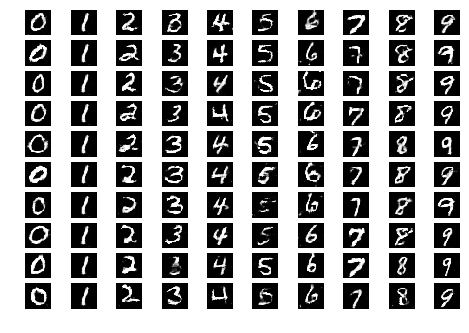

7401 [D loss: 1.633517, acc.: 46.88%, op_acc: 35.94%] [G loss: 1.558502]
7402 [D loss: 1.618728, acc.: 46.88%, op_acc: 45.31%] [G loss: 1.498793]
7403 [D loss: 1.459667, acc.: 46.88%, op_acc: 57.81%] [G loss: 1.649963]
7404 [D loss: 1.725804, acc.: 50.00%, op_acc: 39.06%] [G loss: 1.554110]
7405 [D loss: 1.491368, acc.: 67.19%, op_acc: 43.75%] [G loss: 1.557732]
7406 [D loss: 1.742270, acc.: 42.19%, op_acc: 37.50%] [G loss: 1.588205]
7407 [D loss: 1.602090, acc.: 50.00%, op_acc: 43.75%] [G loss: 1.486551]
7408 [D loss: 1.699548, acc.: 54.69%, op_acc: 34.38%] [G loss: 1.605633]
7409 [D loss: 1.606591, acc.: 48.44%, op_acc: 46.88%] [G loss: 1.651149]
7410 [D loss: 1.556622, acc.: 48.44%, op_acc: 43.75%] [G loss: 1.660583]
7411 [D loss: 1.555746, acc.: 56.25%, op_acc: 43.75%] [G loss: 1.585820]
7412 [D loss: 1.429538, acc.: 59.38%, op_acc: 53.12%] [G loss: 1.845571]
7413 [D loss: 1.615382, acc.: 54.69%, op_acc: 37.50%] [G loss: 1.806807]
7414 [D loss: 1.581415, acc.: 45.31%, op_acc: 48.44

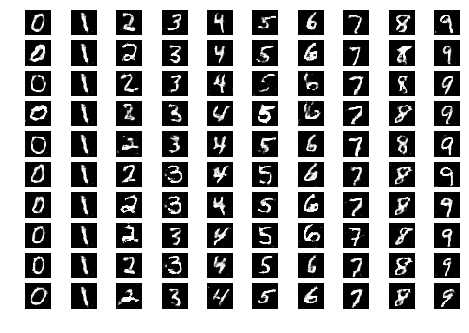

7601 [D loss: 1.553836, acc.: 56.25%, op_acc: 46.88%] [G loss: 1.713247]
7602 [D loss: 1.498060, acc.: 59.38%, op_acc: 46.88%] [G loss: 1.736563]
7603 [D loss: 1.581706, acc.: 57.81%, op_acc: 54.69%] [G loss: 1.738290]
7604 [D loss: 1.440207, acc.: 56.25%, op_acc: 57.81%] [G loss: 1.773284]
7605 [D loss: 1.495461, acc.: 51.56%, op_acc: 50.00%] [G loss: 1.755634]
7606 [D loss: 1.548431, acc.: 65.62%, op_acc: 50.00%] [G loss: 1.721513]
7607 [D loss: 1.523434, acc.: 54.69%, op_acc: 51.56%] [G loss: 1.646269]
7608 [D loss: 1.417882, acc.: 60.94%, op_acc: 53.12%] [G loss: 1.762321]
7609 [D loss: 1.534639, acc.: 56.25%, op_acc: 40.62%] [G loss: 1.610379]
7610 [D loss: 1.607662, acc.: 53.12%, op_acc: 35.94%] [G loss: 1.633451]
7611 [D loss: 1.381927, acc.: 70.31%, op_acc: 59.38%] [G loss: 1.711390]
7612 [D loss: 1.488153, acc.: 50.00%, op_acc: 57.81%] [G loss: 1.659170]
7613 [D loss: 1.592719, acc.: 51.56%, op_acc: 39.06%] [G loss: 1.583733]
7614 [D loss: 1.620586, acc.: 50.00%, op_acc: 40.62

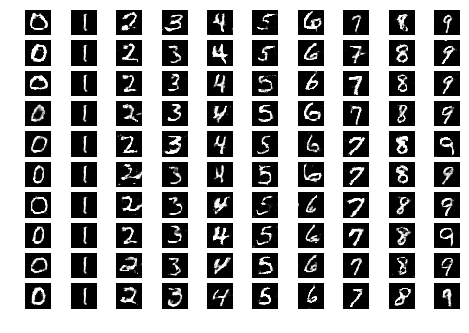

7801 [D loss: 1.569948, acc.: 60.94%, op_acc: 40.62%] [G loss: 1.624146]
7802 [D loss: 1.522343, acc.: 56.25%, op_acc: 45.31%] [G loss: 1.479642]
7803 [D loss: 1.518568, acc.: 50.00%, op_acc: 48.44%] [G loss: 1.596673]
7804 [D loss: 1.455926, acc.: 59.38%, op_acc: 50.00%] [G loss: 1.538327]
7805 [D loss: 1.668927, acc.: 56.25%, op_acc: 39.06%] [G loss: 1.593369]
7806 [D loss: 1.564900, acc.: 48.44%, op_acc: 51.56%] [G loss: 1.586995]
7807 [D loss: 1.562031, acc.: 53.12%, op_acc: 40.62%] [G loss: 1.592895]
7808 [D loss: 1.556934, acc.: 62.50%, op_acc: 40.62%] [G loss: 1.552155]
7809 [D loss: 1.695040, acc.: 53.12%, op_acc: 40.62%] [G loss: 1.631556]
7810 [D loss: 1.570301, acc.: 53.12%, op_acc: 60.94%] [G loss: 1.660801]
7811 [D loss: 1.707609, acc.: 46.88%, op_acc: 35.94%] [G loss: 1.627620]
7812 [D loss: 1.533154, acc.: 50.00%, op_acc: 50.00%] [G loss: 1.693520]
7813 [D loss: 1.443314, acc.: 57.81%, op_acc: 50.00%] [G loss: 1.424241]
7814 [D loss: 1.646146, acc.: 50.00%, op_acc: 39.06

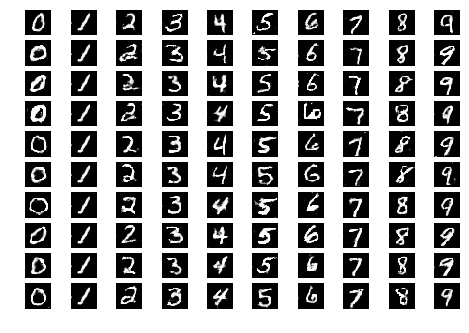

8001 [D loss: 1.521489, acc.: 50.00%, op_acc: 46.88%] [G loss: 1.606305]
8002 [D loss: 1.466223, acc.: 65.62%, op_acc: 60.94%] [G loss: 1.534244]
8003 [D loss: 1.592971, acc.: 59.38%, op_acc: 51.56%] [G loss: 1.663875]
8004 [D loss: 1.495457, acc.: 56.25%, op_acc: 57.81%] [G loss: 1.766660]
8005 [D loss: 1.572992, acc.: 45.31%, op_acc: 45.31%] [G loss: 1.496740]
8006 [D loss: 1.621926, acc.: 53.12%, op_acc: 39.06%] [G loss: 1.796043]
8007 [D loss: 1.541179, acc.: 57.81%, op_acc: 43.75%] [G loss: 1.684662]
8008 [D loss: 1.542738, acc.: 40.62%, op_acc: 53.12%] [G loss: 1.630635]
8009 [D loss: 1.585185, acc.: 45.31%, op_acc: 51.56%] [G loss: 1.697765]
8010 [D loss: 1.528588, acc.: 50.00%, op_acc: 50.00%] [G loss: 1.654330]
8011 [D loss: 1.444299, acc.: 60.94%, op_acc: 56.25%] [G loss: 1.595270]
8012 [D loss: 1.432833, acc.: 60.94%, op_acc: 50.00%] [G loss: 1.779921]
8013 [D loss: 1.501539, acc.: 51.56%, op_acc: 45.31%] [G loss: 1.659197]
8014 [D loss: 1.501244, acc.: 51.56%, op_acc: 60.94

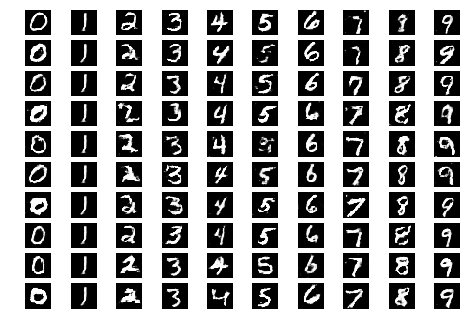

8201 [D loss: 1.514375, acc.: 64.06%, op_acc: 51.56%] [G loss: 1.446311]
8202 [D loss: 1.523660, acc.: 53.12%, op_acc: 43.75%] [G loss: 1.645401]
8203 [D loss: 1.511393, acc.: 42.19%, op_acc: 53.12%] [G loss: 1.559124]
8204 [D loss: 1.542331, acc.: 57.81%, op_acc: 46.88%] [G loss: 1.509101]
8205 [D loss: 1.593308, acc.: 59.38%, op_acc: 42.19%] [G loss: 1.592547]
8206 [D loss: 1.621969, acc.: 50.00%, op_acc: 46.88%] [G loss: 1.671937]
8207 [D loss: 1.597675, acc.: 45.31%, op_acc: 39.06%] [G loss: 1.622841]
8208 [D loss: 1.561676, acc.: 40.62%, op_acc: 43.75%] [G loss: 1.505201]
8209 [D loss: 1.500006, acc.: 48.44%, op_acc: 45.31%] [G loss: 1.621335]
8210 [D loss: 1.379895, acc.: 56.25%, op_acc: 57.81%] [G loss: 1.576094]
8211 [D loss: 1.643069, acc.: 45.31%, op_acc: 34.38%] [G loss: 1.505716]
8212 [D loss: 1.633512, acc.: 42.19%, op_acc: 39.06%] [G loss: 1.518100]
8213 [D loss: 1.519116, acc.: 46.88%, op_acc: 46.88%] [G loss: 1.557557]
8214 [D loss: 1.597116, acc.: 39.06%, op_acc: 45.31

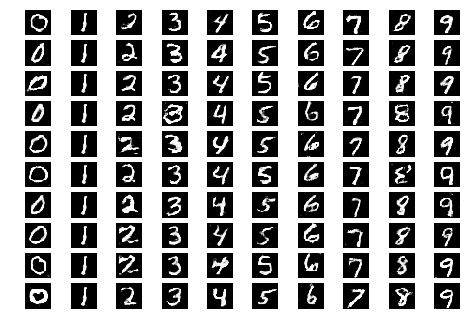

8401 [D loss: 1.471927, acc.: 46.88%, op_acc: 53.12%] [G loss: 1.535409]
8402 [D loss: 1.435686, acc.: 53.12%, op_acc: 51.56%] [G loss: 1.596462]
8403 [D loss: 1.634277, acc.: 56.25%, op_acc: 37.50%] [G loss: 1.501806]
8404 [D loss: 1.520663, acc.: 48.44%, op_acc: 48.44%] [G loss: 1.599155]
8405 [D loss: 1.643976, acc.: 43.75%, op_acc: 32.81%] [G loss: 1.585318]
8406 [D loss: 1.560681, acc.: 50.00%, op_acc: 40.62%] [G loss: 1.549356]
8407 [D loss: 1.560754, acc.: 53.12%, op_acc: 43.75%] [G loss: 1.583697]
8408 [D loss: 1.421431, acc.: 70.31%, op_acc: 65.62%] [G loss: 1.665836]
8409 [D loss: 1.596566, acc.: 60.94%, op_acc: 39.06%] [G loss: 1.635677]
8410 [D loss: 1.578477, acc.: 45.31%, op_acc: 50.00%] [G loss: 1.756114]
8411 [D loss: 1.484940, acc.: 56.25%, op_acc: 54.69%] [G loss: 1.624338]
8412 [D loss: 1.670964, acc.: 50.00%, op_acc: 32.81%] [G loss: 1.544266]
8413 [D loss: 1.510485, acc.: 60.94%, op_acc: 56.25%] [G loss: 1.658365]
8414 [D loss: 1.600084, acc.: 45.31%, op_acc: 46.88

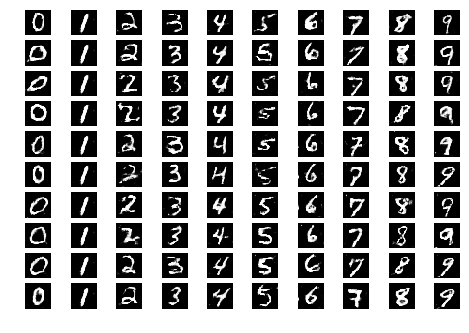

8601 [D loss: 1.597047, acc.: 53.12%, op_acc: 42.19%] [G loss: 1.663612]
8602 [D loss: 1.695694, acc.: 51.56%, op_acc: 40.62%] [G loss: 1.633779]
8603 [D loss: 1.438449, acc.: 53.12%, op_acc: 59.38%] [G loss: 1.516833]
8604 [D loss: 1.579058, acc.: 59.38%, op_acc: 45.31%] [G loss: 1.598566]
8605 [D loss: 1.654983, acc.: 43.75%, op_acc: 34.38%] [G loss: 1.542300]
8606 [D loss: 1.572918, acc.: 60.94%, op_acc: 46.88%] [G loss: 1.663027]
8607 [D loss: 1.396127, acc.: 56.25%, op_acc: 59.38%] [G loss: 1.639838]
8608 [D loss: 1.454880, acc.: 68.75%, op_acc: 51.56%] [G loss: 1.504719]
8609 [D loss: 1.528800, acc.: 54.69%, op_acc: 50.00%] [G loss: 1.495971]
8610 [D loss: 1.629221, acc.: 39.06%, op_acc: 45.31%] [G loss: 1.557997]
8611 [D loss: 1.543520, acc.: 46.88%, op_acc: 50.00%] [G loss: 1.479201]
8612 [D loss: 1.697278, acc.: 42.19%, op_acc: 35.94%] [G loss: 1.564098]
8613 [D loss: 1.577874, acc.: 54.69%, op_acc: 34.38%] [G loss: 1.658979]
8614 [D loss: 1.653592, acc.: 51.56%, op_acc: 35.94

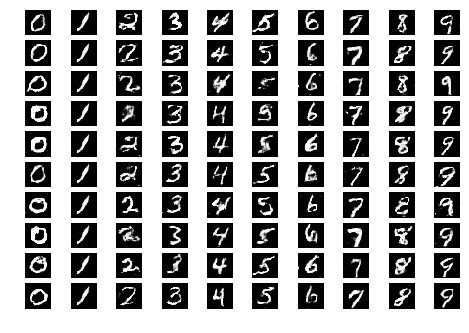

8801 [D loss: 1.430666, acc.: 57.81%, op_acc: 62.50%] [G loss: 1.604237]
8802 [D loss: 1.584349, acc.: 53.12%, op_acc: 43.75%] [G loss: 1.623120]
8803 [D loss: 1.481319, acc.: 51.56%, op_acc: 54.69%] [G loss: 1.665241]
8804 [D loss: 1.533755, acc.: 48.44%, op_acc: 54.69%] [G loss: 1.675640]
8805 [D loss: 1.549257, acc.: 34.38%, op_acc: 50.00%] [G loss: 1.589412]
8806 [D loss: 1.570228, acc.: 51.56%, op_acc: 50.00%] [G loss: 1.656511]
8807 [D loss: 1.389911, acc.: 62.50%, op_acc: 59.38%] [G loss: 1.703815]
8808 [D loss: 1.477092, acc.: 51.56%, op_acc: 43.75%] [G loss: 1.727775]
8809 [D loss: 1.588275, acc.: 43.75%, op_acc: 45.31%] [G loss: 1.521639]
8810 [D loss: 1.531973, acc.: 48.44%, op_acc: 50.00%] [G loss: 1.759243]
8811 [D loss: 1.533152, acc.: 48.44%, op_acc: 43.75%] [G loss: 1.672182]
8812 [D loss: 1.580631, acc.: 39.06%, op_acc: 48.44%] [G loss: 1.571958]
8813 [D loss: 1.425356, acc.: 67.19%, op_acc: 51.56%] [G loss: 1.631557]
8814 [D loss: 1.485429, acc.: 48.44%, op_acc: 53.12

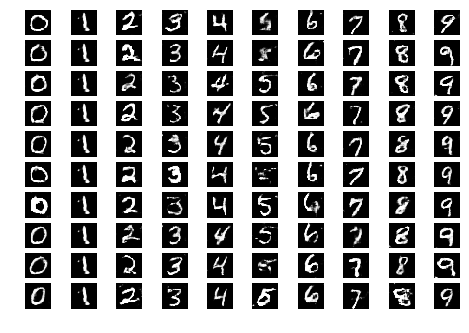

9001 [D loss: 1.418957, acc.: 59.38%, op_acc: 54.69%] [G loss: 1.753727]
9002 [D loss: 1.556491, acc.: 51.56%, op_acc: 34.38%] [G loss: 1.554981]
9003 [D loss: 1.636881, acc.: 60.94%, op_acc: 34.38%] [G loss: 1.669839]
9004 [D loss: 1.532856, acc.: 59.38%, op_acc: 39.06%] [G loss: 1.717393]
9005 [D loss: 1.548077, acc.: 53.12%, op_acc: 43.75%] [G loss: 1.529546]
9006 [D loss: 1.496560, acc.: 54.69%, op_acc: 42.19%] [G loss: 1.812067]
9007 [D loss: 1.609123, acc.: 53.12%, op_acc: 50.00%] [G loss: 1.610965]
9008 [D loss: 1.529369, acc.: 42.19%, op_acc: 42.19%] [G loss: 1.610131]
9009 [D loss: 1.446133, acc.: 50.00%, op_acc: 45.31%] [G loss: 1.581769]
9010 [D loss: 1.510495, acc.: 60.94%, op_acc: 50.00%] [G loss: 1.737194]
9011 [D loss: 1.497051, acc.: 64.06%, op_acc: 53.12%] [G loss: 1.714868]
9012 [D loss: 1.500517, acc.: 62.50%, op_acc: 43.75%] [G loss: 1.761807]
9013 [D loss: 1.551826, acc.: 51.56%, op_acc: 42.19%] [G loss: 1.536489]
9014 [D loss: 1.610781, acc.: 57.81%, op_acc: 42.19

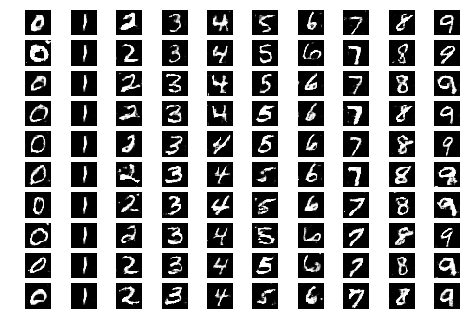

9201 [D loss: 1.441214, acc.: 64.06%, op_acc: 51.56%] [G loss: 1.887421]
9202 [D loss: 1.608124, acc.: 34.38%, op_acc: 34.38%] [G loss: 1.417795]
9203 [D loss: 1.478324, acc.: 50.00%, op_acc: 56.25%] [G loss: 1.540583]
9204 [D loss: 1.489420, acc.: 50.00%, op_acc: 53.12%] [G loss: 1.628413]
9205 [D loss: 1.540377, acc.: 42.19%, op_acc: 48.44%] [G loss: 1.661327]
9206 [D loss: 1.529068, acc.: 42.19%, op_acc: 45.31%] [G loss: 1.624370]
9207 [D loss: 1.683123, acc.: 39.06%, op_acc: 32.81%] [G loss: 1.466775]
9208 [D loss: 1.487469, acc.: 53.12%, op_acc: 46.88%] [G loss: 1.661415]
9209 [D loss: 1.792169, acc.: 48.44%, op_acc: 40.62%] [G loss: 1.489639]
9210 [D loss: 1.467213, acc.: 65.62%, op_acc: 46.88%] [G loss: 1.647740]
9211 [D loss: 1.522853, acc.: 56.25%, op_acc: 59.38%] [G loss: 1.535292]
9212 [D loss: 1.586249, acc.: 54.69%, op_acc: 46.88%] [G loss: 1.643446]
9213 [D loss: 1.540312, acc.: 42.19%, op_acc: 51.56%] [G loss: 1.598122]
9214 [D loss: 1.328851, acc.: 65.62%, op_acc: 64.06

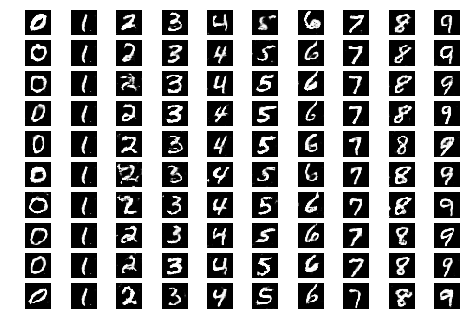

9401 [D loss: 1.579983, acc.: 46.88%, op_acc: 40.62%] [G loss: 1.574746]
9402 [D loss: 1.554596, acc.: 43.75%, op_acc: 43.75%] [G loss: 1.617931]
9403 [D loss: 1.450503, acc.: 43.75%, op_acc: 45.31%] [G loss: 1.596394]
9404 [D loss: 1.549917, acc.: 43.75%, op_acc: 45.31%] [G loss: 1.564996]
9405 [D loss: 1.496987, acc.: 50.00%, op_acc: 48.44%] [G loss: 1.556505]
9406 [D loss: 1.579976, acc.: 51.56%, op_acc: 50.00%] [G loss: 1.559141]
9407 [D loss: 1.522096, acc.: 48.44%, op_acc: 45.31%] [G loss: 1.689210]
9408 [D loss: 1.498527, acc.: 53.12%, op_acc: 57.81%] [G loss: 1.695111]
9409 [D loss: 1.553055, acc.: 54.69%, op_acc: 35.94%] [G loss: 1.512718]
9410 [D loss: 1.525922, acc.: 51.56%, op_acc: 43.75%] [G loss: 1.693808]
9411 [D loss: 1.395875, acc.: 68.75%, op_acc: 57.81%] [G loss: 1.725454]
9412 [D loss: 1.542360, acc.: 51.56%, op_acc: 50.00%] [G loss: 1.604128]
9413 [D loss: 1.560492, acc.: 50.00%, op_acc: 46.88%] [G loss: 1.588083]
9414 [D loss: 1.641908, acc.: 46.88%, op_acc: 45.31

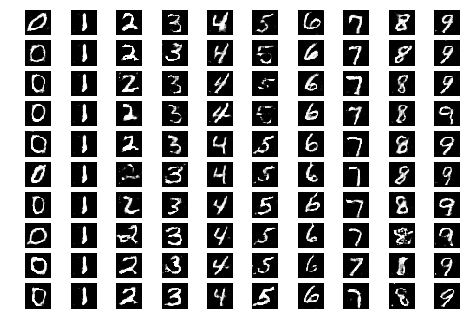

9601 [D loss: 1.539914, acc.: 53.12%, op_acc: 50.00%] [G loss: 1.595261]
9602 [D loss: 1.488908, acc.: 42.19%, op_acc: 51.56%] [G loss: 1.610841]
9603 [D loss: 1.476180, acc.: 65.62%, op_acc: 50.00%] [G loss: 1.598306]
9604 [D loss: 1.508783, acc.: 51.56%, op_acc: 42.19%] [G loss: 1.755126]
9605 [D loss: 1.493446, acc.: 50.00%, op_acc: 56.25%] [G loss: 1.510870]
9606 [D loss: 1.565317, acc.: 51.56%, op_acc: 45.31%] [G loss: 1.560737]
9607 [D loss: 1.528595, acc.: 51.56%, op_acc: 46.88%] [G loss: 1.637698]
9608 [D loss: 1.457512, acc.: 50.00%, op_acc: 53.12%] [G loss: 1.558923]
9609 [D loss: 1.480512, acc.: 45.31%, op_acc: 43.75%] [G loss: 1.569720]
9610 [D loss: 1.506645, acc.: 50.00%, op_acc: 53.12%] [G loss: 1.600870]
9611 [D loss: 1.383141, acc.: 62.50%, op_acc: 59.38%] [G loss: 1.586125]
9612 [D loss: 1.437261, acc.: 45.31%, op_acc: 57.81%] [G loss: 1.547152]
9613 [D loss: 1.661685, acc.: 43.75%, op_acc: 25.00%] [G loss: 1.577073]
9614 [D loss: 1.560407, acc.: 51.56%, op_acc: 45.31

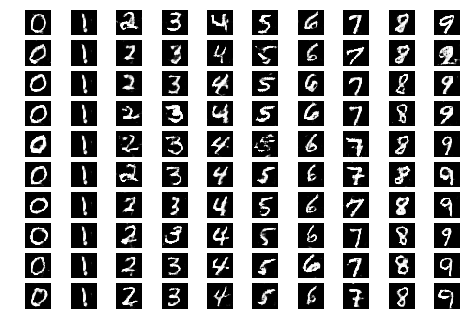

9801 [D loss: 1.396267, acc.: 65.62%, op_acc: 50.00%] [G loss: 1.405464]
9802 [D loss: 1.461940, acc.: 64.06%, op_acc: 53.12%] [G loss: 1.806990]
9803 [D loss: 1.553370, acc.: 37.50%, op_acc: 54.69%] [G loss: 1.413276]
9804 [D loss: 1.562639, acc.: 53.12%, op_acc: 53.12%] [G loss: 1.761250]
9805 [D loss: 1.424924, acc.: 59.38%, op_acc: 51.56%] [G loss: 1.659622]
9806 [D loss: 1.631300, acc.: 43.75%, op_acc: 37.50%] [G loss: 1.635460]
9807 [D loss: 1.529272, acc.: 45.31%, op_acc: 40.62%] [G loss: 1.554647]
9808 [D loss: 1.717910, acc.: 32.81%, op_acc: 34.38%] [G loss: 1.574031]
9809 [D loss: 1.534152, acc.: 51.56%, op_acc: 53.12%] [G loss: 1.538137]
9810 [D loss: 1.449179, acc.: 43.75%, op_acc: 53.12%] [G loss: 1.578796]
9811 [D loss: 1.722113, acc.: 42.19%, op_acc: 35.94%] [G loss: 1.604612]
9812 [D loss: 1.457453, acc.: 51.56%, op_acc: 56.25%] [G loss: 1.650917]
9813 [D loss: 1.449337, acc.: 51.56%, op_acc: 50.00%] [G loss: 1.583212]
9814 [D loss: 1.720426, acc.: 40.62%, op_acc: 43.75

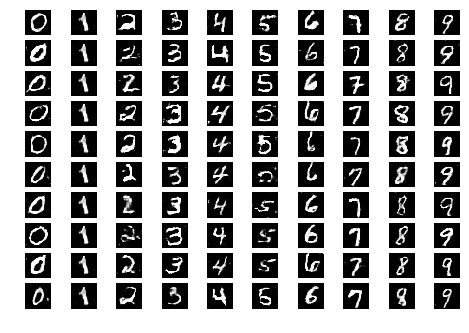

10001 [D loss: 1.662822, acc.: 45.31%, op_acc: 39.06%] [G loss: 1.449435]
10002 [D loss: 1.514981, acc.: 43.75%, op_acc: 56.25%] [G loss: 1.746412]
10003 [D loss: 1.566737, acc.: 53.12%, op_acc: 43.75%] [G loss: 1.616009]
10004 [D loss: 1.625832, acc.: 51.56%, op_acc: 37.50%] [G loss: 1.566375]
10005 [D loss: 1.524507, acc.: 54.69%, op_acc: 43.75%] [G loss: 1.539269]
10006 [D loss: 1.463074, acc.: 62.50%, op_acc: 50.00%] [G loss: 1.495384]
10007 [D loss: 1.431452, acc.: 65.62%, op_acc: 60.94%] [G loss: 1.504659]
10008 [D loss: 1.493476, acc.: 46.88%, op_acc: 50.00%] [G loss: 1.578636]
10009 [D loss: 1.518355, acc.: 57.81%, op_acc: 56.25%] [G loss: 1.599459]
10010 [D loss: 1.619218, acc.: 53.12%, op_acc: 51.56%] [G loss: 1.495782]
10011 [D loss: 1.467427, acc.: 50.00%, op_acc: 45.31%] [G loss: 1.517121]
10012 [D loss: 1.448168, acc.: 64.06%, op_acc: 50.00%] [G loss: 1.613498]
10013 [D loss: 1.479368, acc.: 64.06%, op_acc: 51.56%] [G loss: 1.543470]
10014 [D loss: 1.593637, acc.: 50.00%,

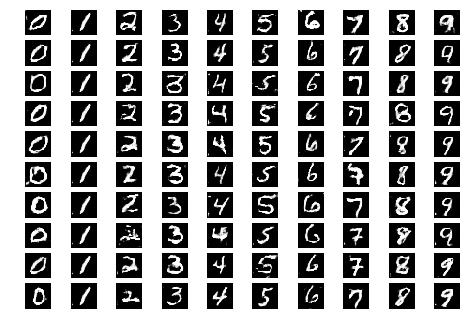

10201 [D loss: 1.322398, acc.: 59.38%, op_acc: 68.75%] [G loss: 1.653144]
10202 [D loss: 1.458392, acc.: 54.69%, op_acc: 56.25%] [G loss: 1.714126]
10203 [D loss: 1.468657, acc.: 57.81%, op_acc: 51.56%] [G loss: 1.608598]
10204 [D loss: 1.511037, acc.: 48.44%, op_acc: 53.12%] [G loss: 1.827292]
10205 [D loss: 1.644599, acc.: 42.19%, op_acc: 43.75%] [G loss: 1.636390]
10206 [D loss: 1.528528, acc.: 59.38%, op_acc: 56.25%] [G loss: 1.767166]
10207 [D loss: 1.440854, acc.: 62.50%, op_acc: 51.56%] [G loss: 1.756607]
10208 [D loss: 1.462929, acc.: 62.50%, op_acc: 54.69%] [G loss: 1.685357]
10209 [D loss: 1.540913, acc.: 62.50%, op_acc: 43.75%] [G loss: 1.619233]
10210 [D loss: 1.503475, acc.: 45.31%, op_acc: 42.19%] [G loss: 1.560413]
10211 [D loss: 1.534460, acc.: 48.44%, op_acc: 43.75%] [G loss: 1.562458]
10212 [D loss: 1.472240, acc.: 50.00%, op_acc: 48.44%] [G loss: 1.472541]
10213 [D loss: 1.573889, acc.: 35.94%, op_acc: 37.50%] [G loss: 1.410741]
10214 [D loss: 1.675955, acc.: 46.88%,

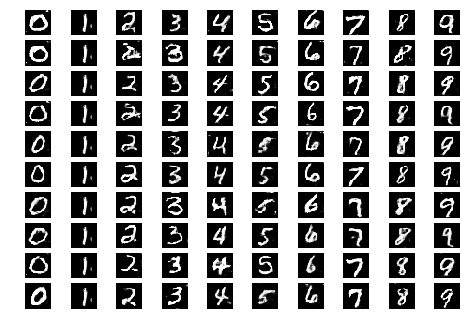

10401 [D loss: 1.577224, acc.: 46.88%, op_acc: 40.62%] [G loss: 1.446183]
10402 [D loss: 1.554332, acc.: 64.06%, op_acc: 45.31%] [G loss: 1.464222]
10403 [D loss: 1.630100, acc.: 60.94%, op_acc: 34.38%] [G loss: 1.522328]
10404 [D loss: 1.676779, acc.: 34.38%, op_acc: 45.31%] [G loss: 1.538460]
10405 [D loss: 1.601365, acc.: 48.44%, op_acc: 46.88%] [G loss: 1.616063]
10406 [D loss: 1.458498, acc.: 54.69%, op_acc: 46.88%] [G loss: 1.525097]
10407 [D loss: 1.462241, acc.: 42.19%, op_acc: 53.12%] [G loss: 1.494573]
10408 [D loss: 1.599577, acc.: 45.31%, op_acc: 43.75%] [G loss: 1.599071]
10409 [D loss: 1.600141, acc.: 64.06%, op_acc: 57.81%] [G loss: 1.612666]
10410 [D loss: 1.541376, acc.: 51.56%, op_acc: 37.50%] [G loss: 1.581135]
10411 [D loss: 1.536581, acc.: 48.44%, op_acc: 42.19%] [G loss: 1.504159]
10412 [D loss: 1.706268, acc.: 46.88%, op_acc: 31.25%] [G loss: 1.585107]
10413 [D loss: 1.476012, acc.: 62.50%, op_acc: 43.75%] [G loss: 1.535359]
10414 [D loss: 1.523863, acc.: 45.31%,

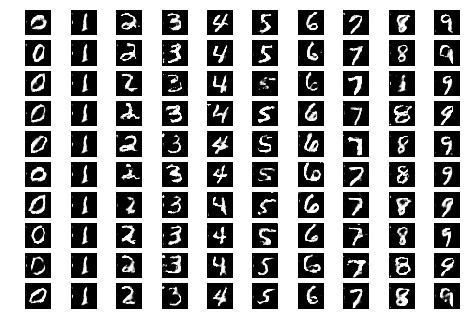

10601 [D loss: 1.550557, acc.: 53.12%, op_acc: 42.19%] [G loss: 1.556569]
10602 [D loss: 1.595208, acc.: 57.81%, op_acc: 42.19%] [G loss: 1.594334]
10603 [D loss: 1.523377, acc.: 51.56%, op_acc: 45.31%] [G loss: 1.632150]
10604 [D loss: 1.417212, acc.: 53.12%, op_acc: 59.38%] [G loss: 1.572271]
10605 [D loss: 1.553600, acc.: 51.56%, op_acc: 45.31%] [G loss: 1.617147]
10606 [D loss: 1.714188, acc.: 37.50%, op_acc: 31.25%] [G loss: 1.579967]
10607 [D loss: 1.599689, acc.: 46.88%, op_acc: 37.50%] [G loss: 1.535191]
10608 [D loss: 1.494191, acc.: 57.81%, op_acc: 45.31%] [G loss: 1.614403]
10609 [D loss: 1.460644, acc.: 60.94%, op_acc: 56.25%] [G loss: 1.749863]
10610 [D loss: 1.553235, acc.: 53.12%, op_acc: 37.50%] [G loss: 1.679087]
10611 [D loss: 1.547451, acc.: 43.75%, op_acc: 46.88%] [G loss: 1.681289]
10612 [D loss: 1.485206, acc.: 54.69%, op_acc: 59.38%] [G loss: 1.605377]
10613 [D loss: 1.440860, acc.: 53.12%, op_acc: 57.81%] [G loss: 1.805983]
10614 [D loss: 1.521996, acc.: 51.56%,

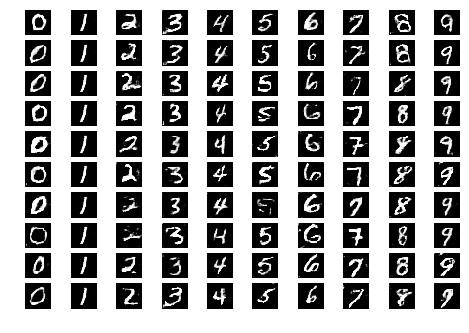

10801 [D loss: 1.590213, acc.: 62.50%, op_acc: 39.06%] [G loss: 1.489034]
10802 [D loss: 1.525277, acc.: 54.69%, op_acc: 53.12%] [G loss: 1.523018]
10803 [D loss: 1.741418, acc.: 51.56%, op_acc: 34.38%] [G loss: 1.576931]
10804 [D loss: 1.556425, acc.: 59.38%, op_acc: 40.62%] [G loss: 1.553216]
10805 [D loss: 1.474308, acc.: 45.31%, op_acc: 56.25%] [G loss: 1.593028]
10806 [D loss: 1.508298, acc.: 50.00%, op_acc: 46.88%] [G loss: 1.556248]
10807 [D loss: 1.508758, acc.: 46.88%, op_acc: 46.88%] [G loss: 1.531829]
10808 [D loss: 1.728832, acc.: 37.50%, op_acc: 37.50%] [G loss: 1.565443]
10809 [D loss: 1.601843, acc.: 46.88%, op_acc: 45.31%] [G loss: 1.623899]
10810 [D loss: 1.487011, acc.: 46.88%, op_acc: 45.31%] [G loss: 1.640706]
10811 [D loss: 1.538749, acc.: 53.12%, op_acc: 45.31%] [G loss: 1.466038]
10812 [D loss: 1.660947, acc.: 54.69%, op_acc: 43.75%] [G loss: 1.699148]
10813 [D loss: 1.505647, acc.: 56.25%, op_acc: 56.25%] [G loss: 1.628816]
10814 [D loss: 1.563247, acc.: 48.44%,

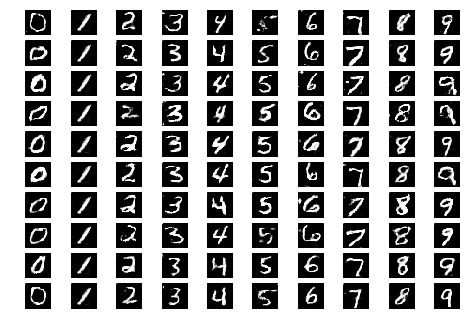

11001 [D loss: 1.409254, acc.: 54.69%, op_acc: 56.25%] [G loss: 1.587991]
11002 [D loss: 1.532502, acc.: 56.25%, op_acc: 45.31%] [G loss: 1.712032]
11003 [D loss: 1.638554, acc.: 46.88%, op_acc: 46.88%] [G loss: 1.577749]
11004 [D loss: 1.511313, acc.: 56.25%, op_acc: 43.75%] [G loss: 1.748506]
11005 [D loss: 1.471847, acc.: 57.81%, op_acc: 51.56%] [G loss: 1.660846]
11006 [D loss: 1.441536, acc.: 56.25%, op_acc: 51.56%] [G loss: 1.672294]
11007 [D loss: 1.477930, acc.: 54.69%, op_acc: 51.56%] [G loss: 1.586970]
11008 [D loss: 1.601929, acc.: 48.44%, op_acc: 34.38%] [G loss: 1.481861]
11009 [D loss: 1.423519, acc.: 53.12%, op_acc: 54.69%] [G loss: 1.657744]
11010 [D loss: 1.496964, acc.: 54.69%, op_acc: 57.81%] [G loss: 1.654543]
11011 [D loss: 1.484887, acc.: 51.56%, op_acc: 50.00%] [G loss: 1.648845]
11012 [D loss: 1.429277, acc.: 62.50%, op_acc: 46.88%] [G loss: 1.580216]
11013 [D loss: 1.537085, acc.: 43.75%, op_acc: 50.00%] [G loss: 1.636656]
11014 [D loss: 1.380842, acc.: 59.38%,

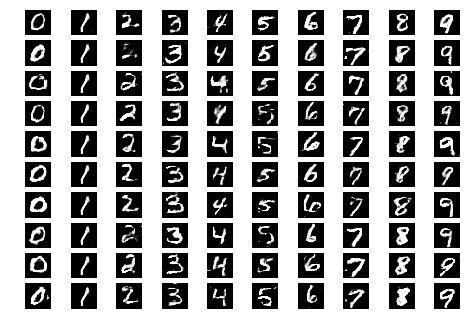

11201 [D loss: 1.610650, acc.: 51.56%, op_acc: 40.62%] [G loss: 1.564806]
11202 [D loss: 1.461431, acc.: 64.06%, op_acc: 50.00%] [G loss: 1.637470]
11203 [D loss: 1.584124, acc.: 46.88%, op_acc: 39.06%] [G loss: 1.623074]
11204 [D loss: 1.506139, acc.: 40.62%, op_acc: 43.75%] [G loss: 1.576623]
11205 [D loss: 1.659948, acc.: 57.81%, op_acc: 39.06%] [G loss: 1.607305]
11206 [D loss: 1.495831, acc.: 62.50%, op_acc: 43.75%] [G loss: 1.654831]
11207 [D loss: 1.484686, acc.: 48.44%, op_acc: 51.56%] [G loss: 1.552502]
11208 [D loss: 1.601436, acc.: 34.38%, op_acc: 40.62%] [G loss: 1.488951]
11209 [D loss: 1.494128, acc.: 48.44%, op_acc: 45.31%] [G loss: 1.507153]
11210 [D loss: 1.518028, acc.: 56.25%, op_acc: 46.88%] [G loss: 1.620968]
11211 [D loss: 1.551570, acc.: 56.25%, op_acc: 51.56%] [G loss: 1.635386]
11212 [D loss: 1.540350, acc.: 48.44%, op_acc: 45.31%] [G loss: 1.574030]
11213 [D loss: 1.556133, acc.: 43.75%, op_acc: 43.75%] [G loss: 1.525738]
11214 [D loss: 1.528444, acc.: 50.00%,

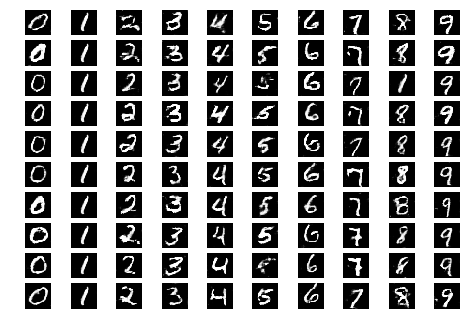

11401 [D loss: 1.526125, acc.: 62.50%, op_acc: 53.12%] [G loss: 1.618135]
11402 [D loss: 1.615792, acc.: 48.44%, op_acc: 43.75%] [G loss: 1.520525]
11403 [D loss: 1.467858, acc.: 57.81%, op_acc: 51.56%] [G loss: 1.571764]
11404 [D loss: 1.488118, acc.: 54.69%, op_acc: 50.00%] [G loss: 1.679234]
11405 [D loss: 1.605011, acc.: 42.19%, op_acc: 40.62%] [G loss: 1.379054]
11406 [D loss: 1.603745, acc.: 50.00%, op_acc: 42.19%] [G loss: 1.748350]
11407 [D loss: 1.538321, acc.: 43.75%, op_acc: 48.44%] [G loss: 1.502254]
11408 [D loss: 1.393269, acc.: 56.25%, op_acc: 53.12%] [G loss: 1.597756]
11409 [D loss: 1.584256, acc.: 45.31%, op_acc: 43.75%] [G loss: 1.489910]
11410 [D loss: 1.499979, acc.: 51.56%, op_acc: 48.44%] [G loss: 1.561809]
11411 [D loss: 1.413223, acc.: 68.75%, op_acc: 54.69%] [G loss: 1.666817]
11412 [D loss: 1.479440, acc.: 46.88%, op_acc: 46.88%] [G loss: 1.672164]
11413 [D loss: 1.506483, acc.: 45.31%, op_acc: 51.56%] [G loss: 1.541821]
11414 [D loss: 1.441633, acc.: 59.38%,

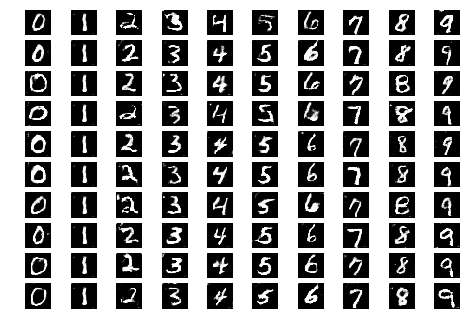

11601 [D loss: 1.687492, acc.: 53.12%, op_acc: 39.06%] [G loss: 1.493177]
11602 [D loss: 1.613508, acc.: 32.81%, op_acc: 40.62%] [G loss: 1.403812]
11603 [D loss: 1.552541, acc.: 45.31%, op_acc: 43.75%] [G loss: 1.633842]
11604 [D loss: 1.473950, acc.: 53.12%, op_acc: 56.25%] [G loss: 1.684391]
11605 [D loss: 1.442088, acc.: 60.94%, op_acc: 48.44%] [G loss: 1.725908]
11606 [D loss: 1.558848, acc.: 35.94%, op_acc: 42.19%] [G loss: 1.581538]
11607 [D loss: 1.510054, acc.: 59.38%, op_acc: 43.75%] [G loss: 1.568482]
11608 [D loss: 1.596507, acc.: 46.88%, op_acc: 35.94%] [G loss: 1.475124]
11609 [D loss: 1.550481, acc.: 43.75%, op_acc: 43.75%] [G loss: 1.629049]
11610 [D loss: 1.702734, acc.: 40.62%, op_acc: 39.06%] [G loss: 1.538571]
11611 [D loss: 1.444385, acc.: 54.69%, op_acc: 54.69%] [G loss: 1.753825]
11612 [D loss: 1.427536, acc.: 59.38%, op_acc: 45.31%] [G loss: 1.616897]
11613 [D loss: 1.444146, acc.: 64.06%, op_acc: 56.25%] [G loss: 1.505213]
11614 [D loss: 1.500602, acc.: 60.94%,

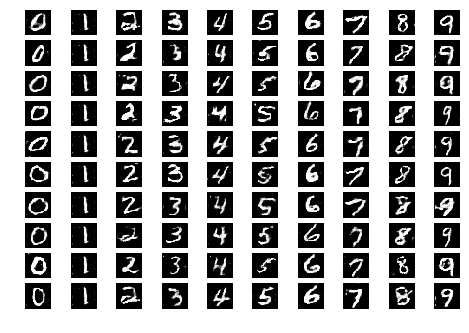

11801 [D loss: 1.488470, acc.: 46.88%, op_acc: 39.06%] [G loss: 1.500149]
11802 [D loss: 1.590961, acc.: 48.44%, op_acc: 45.31%] [G loss: 1.569259]
11803 [D loss: 1.561668, acc.: 42.19%, op_acc: 45.31%] [G loss: 1.528570]
11804 [D loss: 1.500949, acc.: 59.38%, op_acc: 42.19%] [G loss: 1.496596]
11805 [D loss: 1.455066, acc.: 65.62%, op_acc: 51.56%] [G loss: 1.597847]
11806 [D loss: 1.404477, acc.: 59.38%, op_acc: 56.25%] [G loss: 1.683989]
11807 [D loss: 1.485941, acc.: 43.75%, op_acc: 53.12%] [G loss: 1.560006]
11808 [D loss: 1.454037, acc.: 60.94%, op_acc: 48.44%] [G loss: 1.542681]
11809 [D loss: 1.448964, acc.: 54.69%, op_acc: 54.69%] [G loss: 1.539333]
11810 [D loss: 1.484142, acc.: 65.62%, op_acc: 43.75%] [G loss: 1.491681]
11811 [D loss: 1.440368, acc.: 54.69%, op_acc: 54.69%] [G loss: 1.627782]
11812 [D loss: 1.435777, acc.: 57.81%, op_acc: 59.38%] [G loss: 1.694090]
11813 [D loss: 1.457133, acc.: 54.69%, op_acc: 46.88%] [G loss: 1.692648]
11814 [D loss: 1.485270, acc.: 57.81%,

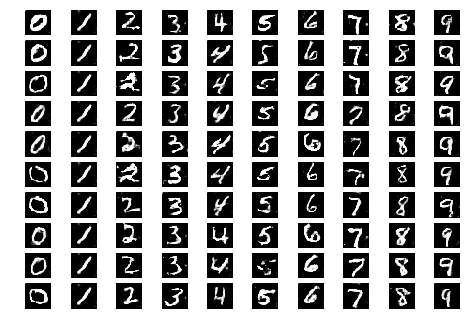

12001 [D loss: 1.486189, acc.: 54.69%, op_acc: 56.25%] [G loss: 1.565372]
12002 [D loss: 1.426844, acc.: 60.94%, op_acc: 60.94%] [G loss: 1.634010]
12003 [D loss: 1.398059, acc.: 54.69%, op_acc: 62.50%] [G loss: 1.744386]
12004 [D loss: 1.483593, acc.: 54.69%, op_acc: 59.38%] [G loss: 1.772671]
12005 [D loss: 1.436426, acc.: 54.69%, op_acc: 56.25%] [G loss: 1.724639]
12006 [D loss: 1.465472, acc.: 67.19%, op_acc: 54.69%] [G loss: 1.676929]
12007 [D loss: 1.497998, acc.: 56.25%, op_acc: 51.56%] [G loss: 1.656231]
12008 [D loss: 1.402693, acc.: 67.19%, op_acc: 59.38%] [G loss: 1.706281]
12009 [D loss: 1.519049, acc.: 51.56%, op_acc: 48.44%] [G loss: 1.657475]
12010 [D loss: 1.508651, acc.: 51.56%, op_acc: 53.12%] [G loss: 1.580104]
12011 [D loss: 1.403002, acc.: 51.56%, op_acc: 67.19%] [G loss: 1.772250]
12012 [D loss: 1.618725, acc.: 53.12%, op_acc: 43.75%] [G loss: 1.626754]
12013 [D loss: 1.459607, acc.: 68.75%, op_acc: 60.94%] [G loss: 1.675865]
12014 [D loss: 1.593256, acc.: 40.62%,

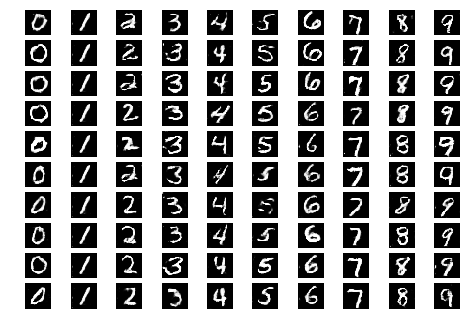

12201 [D loss: 1.529362, acc.: 51.56%, op_acc: 50.00%] [G loss: 1.871049]
12202 [D loss: 1.500241, acc.: 64.06%, op_acc: 50.00%] [G loss: 1.687518]
12203 [D loss: 1.552919, acc.: 51.56%, op_acc: 45.31%] [G loss: 1.772999]
12204 [D loss: 1.635222, acc.: 46.88%, op_acc: 45.31%] [G loss: 1.681393]
12205 [D loss: 1.404783, acc.: 57.81%, op_acc: 56.25%] [G loss: 1.682405]
12206 [D loss: 1.485222, acc.: 50.00%, op_acc: 59.38%] [G loss: 1.577628]
12207 [D loss: 1.484066, acc.: 59.38%, op_acc: 50.00%] [G loss: 1.672334]
12208 [D loss: 1.525034, acc.: 42.19%, op_acc: 45.31%] [G loss: 1.532023]
12209 [D loss: 1.493093, acc.: 54.69%, op_acc: 46.88%] [G loss: 1.616708]
12210 [D loss: 1.559584, acc.: 59.38%, op_acc: 37.50%] [G loss: 1.649585]
12211 [D loss: 1.765819, acc.: 39.06%, op_acc: 28.12%] [G loss: 1.452211]
12212 [D loss: 1.592532, acc.: 53.12%, op_acc: 40.62%] [G loss: 1.492195]
12213 [D loss: 1.656590, acc.: 43.75%, op_acc: 34.38%] [G loss: 1.505772]
12214 [D loss: 1.533166, acc.: 53.12%,

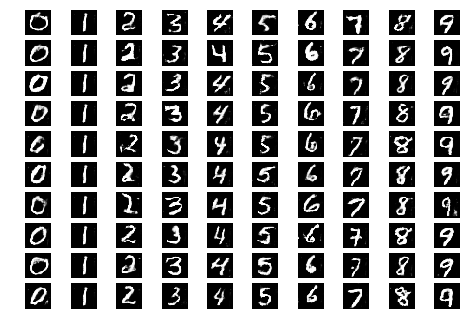

12401 [D loss: 1.563992, acc.: 53.12%, op_acc: 48.44%] [G loss: 1.643159]
12402 [D loss: 1.544799, acc.: 37.50%, op_acc: 40.62%] [G loss: 1.596035]
12403 [D loss: 1.649809, acc.: 39.06%, op_acc: 37.50%] [G loss: 1.526796]
12404 [D loss: 1.523765, acc.: 56.25%, op_acc: 43.75%] [G loss: 1.517039]
12405 [D loss: 1.542887, acc.: 46.88%, op_acc: 46.88%] [G loss: 1.626177]
12406 [D loss: 1.582969, acc.: 56.25%, op_acc: 35.94%] [G loss: 1.504151]
12407 [D loss: 1.500264, acc.: 42.19%, op_acc: 54.69%] [G loss: 1.604999]
12408 [D loss: 1.402044, acc.: 57.81%, op_acc: 57.81%] [G loss: 1.640225]
12409 [D loss: 1.550727, acc.: 50.00%, op_acc: 46.88%] [G loss: 1.609549]
12410 [D loss: 1.579001, acc.: 54.69%, op_acc: 37.50%] [G loss: 1.564585]
12411 [D loss: 1.631254, acc.: 54.69%, op_acc: 48.44%] [G loss: 1.588632]
12412 [D loss: 1.440941, acc.: 57.81%, op_acc: 56.25%] [G loss: 1.655130]
12413 [D loss: 1.507937, acc.: 43.75%, op_acc: 48.44%] [G loss: 1.614408]
12414 [D loss: 1.470137, acc.: 48.44%,

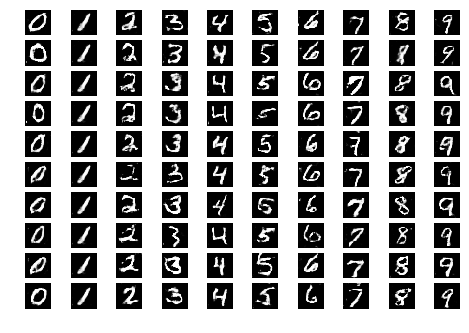

12601 [D loss: 1.504193, acc.: 51.56%, op_acc: 51.56%] [G loss: 1.621555]
12602 [D loss: 1.515115, acc.: 43.75%, op_acc: 50.00%] [G loss: 1.554994]
12603 [D loss: 1.519556, acc.: 56.25%, op_acc: 53.12%] [G loss: 1.701868]
12604 [D loss: 1.529449, acc.: 51.56%, op_acc: 46.88%] [G loss: 1.665897]
12605 [D loss: 1.757189, acc.: 32.81%, op_acc: 31.25%] [G loss: 1.486614]
12606 [D loss: 1.556924, acc.: 46.88%, op_acc: 46.88%] [G loss: 1.566450]
12607 [D loss: 1.525160, acc.: 51.56%, op_acc: 46.88%] [G loss: 1.635868]
12608 [D loss: 1.455987, acc.: 53.12%, op_acc: 57.81%] [G loss: 1.630209]
12609 [D loss: 1.454847, acc.: 67.19%, op_acc: 51.56%] [G loss: 1.639889]
12610 [D loss: 1.483027, acc.: 60.94%, op_acc: 45.31%] [G loss: 1.658159]
12611 [D loss: 1.433806, acc.: 54.69%, op_acc: 53.12%] [G loss: 1.710360]
12612 [D loss: 1.527882, acc.: 37.50%, op_acc: 42.19%] [G loss: 1.783785]
12613 [D loss: 1.509085, acc.: 48.44%, op_acc: 45.31%] [G loss: 1.657854]
12614 [D loss: 1.639612, acc.: 46.88%,

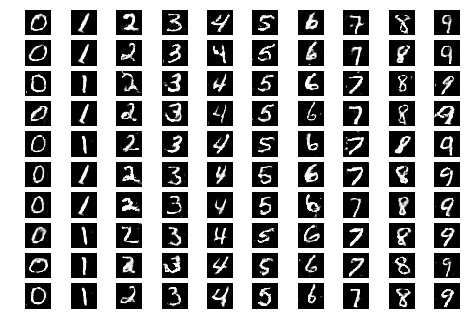

12801 [D loss: 1.481798, acc.: 60.94%, op_acc: 43.75%] [G loss: 1.406343]
12802 [D loss: 1.609752, acc.: 54.69%, op_acc: 39.06%] [G loss: 1.546737]
12803 [D loss: 1.571925, acc.: 42.19%, op_acc: 39.06%] [G loss: 1.457052]
12804 [D loss: 1.596414, acc.: 32.81%, op_acc: 37.50%] [G loss: 1.451428]
12805 [D loss: 1.503324, acc.: 59.38%, op_acc: 51.56%] [G loss: 1.624575]
12806 [D loss: 1.510226, acc.: 45.31%, op_acc: 51.56%] [G loss: 1.600129]
12807 [D loss: 1.522942, acc.: 42.19%, op_acc: 48.44%] [G loss: 1.543704]
12808 [D loss: 1.576569, acc.: 59.38%, op_acc: 35.94%] [G loss: 1.615260]
12809 [D loss: 1.527961, acc.: 53.12%, op_acc: 48.44%] [G loss: 1.627029]
12810 [D loss: 1.504341, acc.: 51.56%, op_acc: 50.00%] [G loss: 1.605736]
12811 [D loss: 1.629442, acc.: 39.06%, op_acc: 32.81%] [G loss: 1.454163]
12812 [D loss: 1.526927, acc.: 56.25%, op_acc: 39.06%] [G loss: 1.417372]
12813 [D loss: 1.551727, acc.: 50.00%, op_acc: 56.25%] [G loss: 1.552197]
12814 [D loss: 1.687120, acc.: 53.12%,

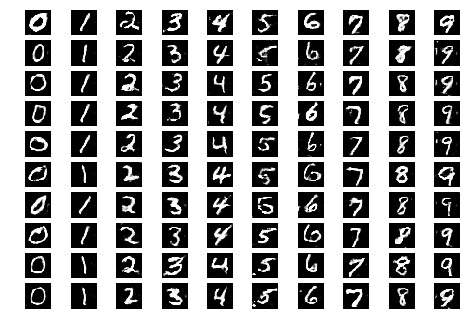

13001 [D loss: 1.392604, acc.: 64.06%, op_acc: 57.81%] [G loss: 1.730202]
13002 [D loss: 1.568014, acc.: 42.19%, op_acc: 45.31%] [G loss: 1.474292]
13003 [D loss: 1.431646, acc.: 67.19%, op_acc: 51.56%] [G loss: 1.580878]
13004 [D loss: 1.563212, acc.: 51.56%, op_acc: 43.75%] [G loss: 1.575051]
13005 [D loss: 1.574125, acc.: 45.31%, op_acc: 39.06%] [G loss: 1.653462]
13006 [D loss: 1.595449, acc.: 35.94%, op_acc: 32.81%] [G loss: 1.521000]
13007 [D loss: 1.506001, acc.: 51.56%, op_acc: 46.88%] [G loss: 1.624118]
13008 [D loss: 1.479296, acc.: 59.38%, op_acc: 43.75%] [G loss: 1.526028]
13009 [D loss: 1.597069, acc.: 46.88%, op_acc: 50.00%] [G loss: 1.458080]
13010 [D loss: 1.475924, acc.: 56.25%, op_acc: 45.31%] [G loss: 1.673672]
13011 [D loss: 1.571287, acc.: 40.62%, op_acc: 37.50%] [G loss: 1.389525]
13012 [D loss: 1.517424, acc.: 57.81%, op_acc: 42.19%] [G loss: 1.566655]
13013 [D loss: 1.625220, acc.: 53.12%, op_acc: 40.62%] [G loss: 1.532115]
13014 [D loss: 1.563624, acc.: 57.81%,

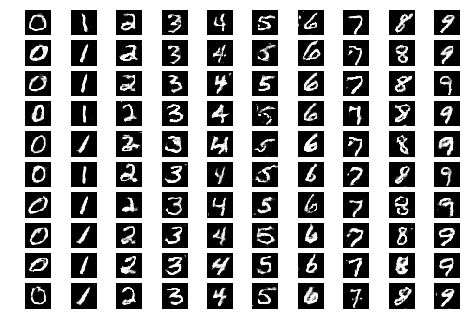

13201 [D loss: 1.541291, acc.: 34.38%, op_acc: 48.44%] [G loss: 1.501534]
13202 [D loss: 1.480737, acc.: 54.69%, op_acc: 46.88%] [G loss: 1.544214]
13203 [D loss: 1.464134, acc.: 56.25%, op_acc: 48.44%] [G loss: 1.566993]
13204 [D loss: 1.555326, acc.: 50.00%, op_acc: 39.06%] [G loss: 1.596362]
13205 [D loss: 1.615689, acc.: 40.62%, op_acc: 28.12%] [G loss: 1.612400]
13206 [D loss: 1.578288, acc.: 50.00%, op_acc: 35.94%] [G loss: 1.560726]
13207 [D loss: 1.518423, acc.: 46.88%, op_acc: 43.75%] [G loss: 1.444065]
13208 [D loss: 1.526569, acc.: 35.94%, op_acc: 50.00%] [G loss: 1.557383]
13209 [D loss: 1.487177, acc.: 64.06%, op_acc: 60.94%] [G loss: 1.516908]
13210 [D loss: 1.557683, acc.: 40.62%, op_acc: 42.19%] [G loss: 1.509390]
13211 [D loss: 1.469642, acc.: 48.44%, op_acc: 57.81%] [G loss: 1.589727]
13212 [D loss: 1.611436, acc.: 57.81%, op_acc: 34.38%] [G loss: 1.600363]
13213 [D loss: 1.496748, acc.: 51.56%, op_acc: 46.88%] [G loss: 1.545421]
13214 [D loss: 1.567013, acc.: 45.31%,

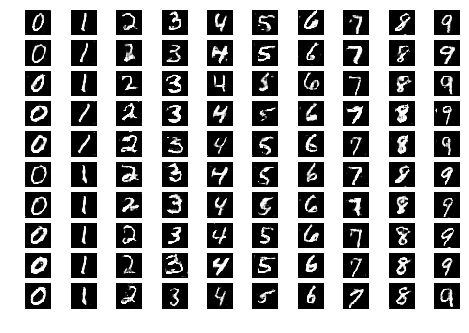

13401 [D loss: 1.620395, acc.: 50.00%, op_acc: 34.38%] [G loss: 1.581059]
13402 [D loss: 1.641027, acc.: 35.94%, op_acc: 45.31%] [G loss: 1.407921]
13403 [D loss: 1.517702, acc.: 40.62%, op_acc: 43.75%] [G loss: 1.629547]
13404 [D loss: 1.483863, acc.: 45.31%, op_acc: 53.12%] [G loss: 1.537919]
13405 [D loss: 1.523811, acc.: 50.00%, op_acc: 51.56%] [G loss: 1.544815]
13406 [D loss: 1.492332, acc.: 53.12%, op_acc: 48.44%] [G loss: 1.588713]
13407 [D loss: 1.537822, acc.: 40.62%, op_acc: 43.75%] [G loss: 1.522465]
13408 [D loss: 1.503769, acc.: 43.75%, op_acc: 50.00%] [G loss: 1.521389]
13409 [D loss: 1.480366, acc.: 51.56%, op_acc: 50.00%] [G loss: 1.489933]
13410 [D loss: 1.546269, acc.: 54.69%, op_acc: 35.94%] [G loss: 1.557889]
13411 [D loss: 1.489800, acc.: 39.06%, op_acc: 48.44%] [G loss: 1.542444]
13412 [D loss: 1.450850, acc.: 53.12%, op_acc: 62.50%] [G loss: 1.508753]
13413 [D loss: 1.435259, acc.: 53.12%, op_acc: 50.00%] [G loss: 1.555177]
13414 [D loss: 1.534946, acc.: 53.12%,

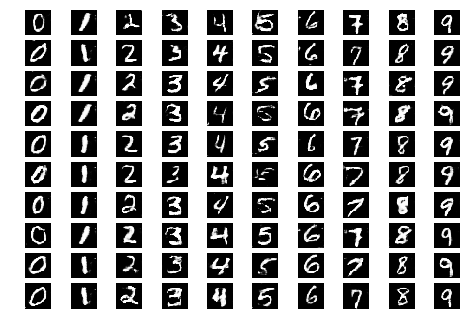

13601 [D loss: 1.473319, acc.: 37.50%, op_acc: 46.88%] [G loss: 1.637101]
13602 [D loss: 1.524241, acc.: 43.75%, op_acc: 43.75%] [G loss: 1.457724]
13603 [D loss: 1.553004, acc.: 45.31%, op_acc: 43.75%] [G loss: 1.422884]
13604 [D loss: 1.555898, acc.: 45.31%, op_acc: 35.94%] [G loss: 1.409502]
13605 [D loss: 1.482779, acc.: 62.50%, op_acc: 40.62%] [G loss: 1.527655]
13606 [D loss: 1.619934, acc.: 42.19%, op_acc: 39.06%] [G loss: 1.511048]
13607 [D loss: 1.436389, acc.: 60.94%, op_acc: 53.12%] [G loss: 1.680512]
13608 [D loss: 1.468268, acc.: 54.69%, op_acc: 48.44%] [G loss: 1.508327]
13609 [D loss: 1.579794, acc.: 42.19%, op_acc: 40.62%] [G loss: 1.528851]
13610 [D loss: 1.529257, acc.: 50.00%, op_acc: 46.88%] [G loss: 1.608561]
13611 [D loss: 1.619293, acc.: 46.88%, op_acc: 39.06%] [G loss: 1.536573]
13612 [D loss: 1.549155, acc.: 45.31%, op_acc: 39.06%] [G loss: 1.422590]
13613 [D loss: 1.442204, acc.: 54.69%, op_acc: 46.88%] [G loss: 1.613061]
13614 [D loss: 1.517890, acc.: 50.00%,

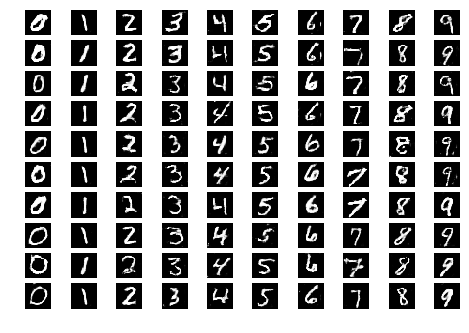

13801 [D loss: 1.511088, acc.: 45.31%, op_acc: 39.06%] [G loss: 1.598508]
13802 [D loss: 1.521481, acc.: 51.56%, op_acc: 43.75%] [G loss: 1.457074]
13803 [D loss: 1.530506, acc.: 59.38%, op_acc: 46.88%] [G loss: 1.554586]
13804 [D loss: 1.421073, acc.: 65.62%, op_acc: 62.50%] [G loss: 1.633662]
13805 [D loss: 1.402287, acc.: 56.25%, op_acc: 57.81%] [G loss: 1.657855]
13806 [D loss: 1.660506, acc.: 43.75%, op_acc: 40.62%] [G loss: 1.417205]
13807 [D loss: 1.586829, acc.: 40.62%, op_acc: 48.44%] [G loss: 1.513275]
13808 [D loss: 1.580911, acc.: 43.75%, op_acc: 39.06%] [G loss: 1.440734]
13809 [D loss: 1.655956, acc.: 45.31%, op_acc: 26.56%] [G loss: 1.451705]
13810 [D loss: 1.498305, acc.: 56.25%, op_acc: 43.75%] [G loss: 1.497468]
13811 [D loss: 1.454967, acc.: 60.94%, op_acc: 46.88%] [G loss: 1.561679]
13812 [D loss: 1.615868, acc.: 59.38%, op_acc: 46.88%] [G loss: 1.579204]
13813 [D loss: 1.515524, acc.: 60.94%, op_acc: 43.75%] [G loss: 1.586865]
13814 [D loss: 1.451827, acc.: 51.56%,

In [12]:
acgan = ACGAN()
acgan.train(epochs=14000, batch_size=32, sample_interval=200)

In [0]:
noise = np.random.normal(0, 1, (1, 100))

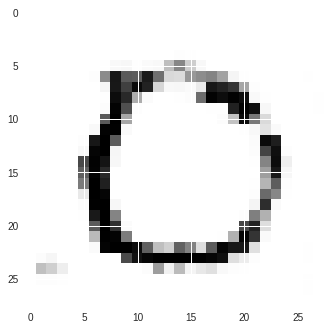

In [20]:
labels = np.array(0).reshape([-1, 1])
images = acgan.generate(noise, labels)
plt.imshow(images[0, :, :, 0])
plt.show()

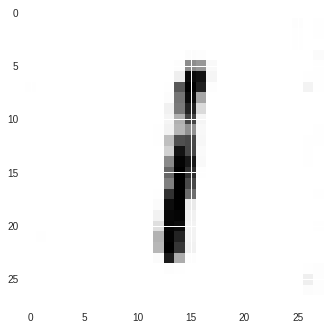

In [21]:
labels = np.array(1).reshape([-1, 1])
images = acgan.generate(noise, labels)
plt.imshow(images[0, :, :, 0])
plt.show()

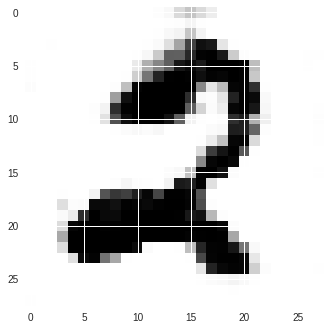

In [22]:
labels = np.array(2).reshape([-1, 1])
images = acgan.generate(noise, labels)
plt.imshow(images[0, :, :, 0])
plt.show()

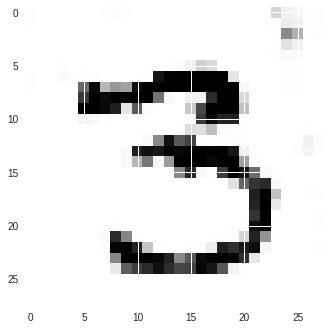

In [23]:
labels = np.array(3).reshape([-1, 1])
images = acgan.generate(noise, labels)
plt.imshow(images[0, :, :, 0])
plt.show()

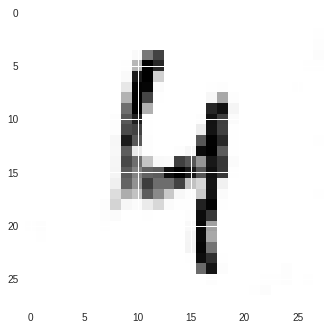

In [24]:
labels = np.array(4).reshape([-1, 1])
images = acgan.generate(noise, labels)
plt.imshow(images[0, :, :, 0])
plt.show()

In [0]:
noise = np.random.normal(0, 1, (1, 100))

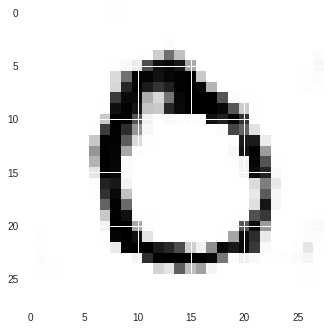

In [26]:
labels = np.array(0).reshape([-1, 1])
images = acgan.generate(noise, labels)
plt.imshow(images[0, :, :, 0])
plt.show()

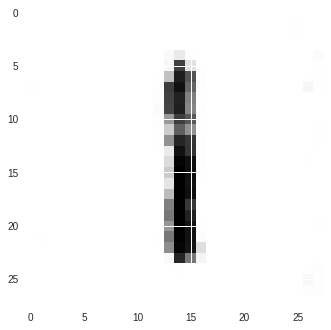

In [27]:
labels = np.array(1).reshape([-1, 1])
images = acgan.generate(noise, labels)
plt.imshow(images[0, :, :, 0])
plt.show()

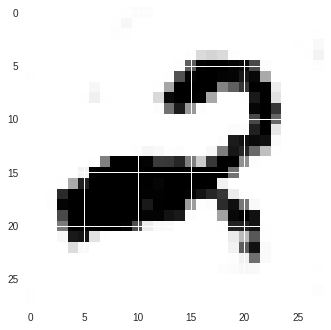

In [28]:
labels = np.array(2).reshape([-1, 1])
images = acgan.generate(noise, labels)
plt.imshow(images[0, :, :, 0])
plt.show()

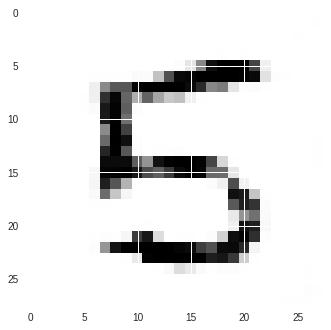

In [29]:
labels = np.array(5).reshape([-1, 1])
images = acgan.generate(noise, labels)
plt.imshow(images[0, :, :, 0])
plt.show()

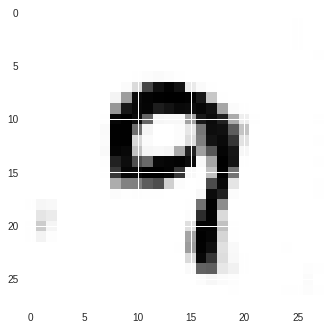

In [30]:
labels = np.array(9).reshape([-1, 1])
images = acgan.generate(noise, labels)
plt.imshow(images[0, :, :, 0])
plt.show()